In [1]:

import pandas as pd 
import numpy as np 
from collections import defaultdict
import pyreadstat
from datetime import datetime
from scipy import stats

pd.set_option('display.max_columns', None)

In [2]:
w1 = pd.read_spss('./datenstze/W1_PPS_02.sav')
w2 = pd.read_spss('./datenstze/W2_PPS_01.sav')
w3 = pd.read_spss('./datenstze/W3_PPS_Datensatz01.sav')
w4 = pd.read_spss('./datenstze/W4_PPS_SoSe21_v1.sav')
w5 = pd.read_spss('./datenstze/W5_PPS_02.sav')

## Files
# 1. './datenstze/Welle6_v2_4_Gruppen.sav'
# 2. './datenstze/Welle6_v3_Gruppen.sav'
w6 = pd.read_spss('./datenstze/Welle6_v3_Gruppen.sav')
w8 = pd.read_spss('./datenstze/Welle8_v2.sav')


In [31]:
w1

,CASE,SERIAL,REF,QUESTNNR,MODE,STARTED,D1,D2,D3_01,D3_02,D3_03,D4_01,D4_02,D4_03,D5,D6,D6_01,D6_02,D6_03,D6_04,D7_01,D7_02,D8_01,D8_02,D9_01,D9_02,D10,S1,S2,S3,S4,S5,F1,F2,F3,F4,F5,F6,F8,F8_01,F8_02,F8_03,F8_04,F8_05,F8_06,F8_07,F8_08,F8_09,F8_10,F8_11,F8_12,F8_13,F9_01,F9_02,F9_03,F10,B1_01,B1_02,B1_03,B1_04,B1_05,B1_06,B2,B2_anz,B2_01,B2_02,B2_03,B2_04,B2_05,B2_06,B2_07,B2_08,B2_09,B2_10,B2_11,B2_12,B2_13,B2_14,B2_15,B2_16,B3,B4,B5,B6,B7_01,B7_02,B7_03,B7_04,B8_01,B8_02,B8_03,B8_04,B8_05,L1_01,L1_02,L1_03,L1_04,L1_05,L1_06,L1_07,L1_08,L1_09,L1_10,L1_11,L1_09_offen,L1_10_anz,L1_10_01,L1_10_02,L1_10_03,L1_10_04,L1_10_05,L1_10_06,L1_10_07,L1_10_08,VP_L01,VP_L02,VP_L03,VP_L04,VP_L05,VP_L06,VP_L07,VP_L08,VP_L09,VP_L10,VP_L11,VP_L12,VP_L13,VP_L14,VP_L15,VP_L16,VP_L17,VP_L18,VP_L19,VP_L20,VP_L21,VP_L22,VP_L23,VP_L24,VP_L25,VP_L26,VP_L27,VP_L28,VP_L29,VP_L30,VP_L31,VP_L32,VP_L33,VP_L34,VP_L35,VP_L36,VP_L37,VP_L38,VP_L39,VP_L40,VP_L41,VP_L42,FP_L01,FP_L02,FP_L03,FP_L04,FP_L05,FP_L06,FP_L07,FP_L08,FP_L09,FP_L10,FP_L11,FP_L12,FP_L13,FP_L14,FP_L15,FP_L16,FP_L17,FP_L18,FP_L19,FP_L20,FP_L21,FP_L22,FP_L23,FP_L24,FP_L25,FP_L26,FP_L27,FP_L28,FP_L29,FP_L30,FP_L31,FP_L32,FP_L33,VP_L50,VP_L51,VP_L52,VP_L53,VP_L54,VP_L55,VP_L56,FP_L50,FP_L51,FP_L52,FP_L53,FP_L54,FP_L55,FP_L56,TP_1_bw,TP_2_bw,TP_3_bw,TP_4_bw,TP_5_bw,TP_6_bw,TP_1_fd,TP_2_fd,TP_3_fd,TP_4_fd,TP_5_fd,TP_6_fd,TIME001,TIME002,TIME003,TIME004,TIME005,TIME006,TIME007,TIME008,TIME009,TIME010,TIME011,TIME_SUM,MAILSENT,LASTDATA,FINISHED,Q_VIEWER,LASTPAGE,MAXPAGE,MISSING,MISSREL,TIME_RSI,DEG_TIME,filter_$,S_Gesamt,S_Gesamt_2,D5_dichotom,F_Gesamt,Fach_A,Fach_B,Fach_Erw,LLLL_NEU,neu_L01,neu_L02,neu_L03,neu_L04,neu_L05,neu_L06,neu_L07,neu_L08,neu_L09_regelverstöße,neu_L10_Konflikte,neu_L11_SPF,neu_L12_körperl,neu_L13_Krisen,neu_L15,neu_L16_Therorien,neu_L17_Absprache,neu_L18_Lernstand,neu_L19_individuell,neu_L20_differenzierteAufgaben,neu_L21_medienauswah,neu_L22_inhaltsspezfisch,neu_L23_computer,neu_L24_Fehler,neu_L25_selbstkontrolle,neu_L26_Strategien,neu_L27_diskutiert,neu_L28_kooperativ,neu_L29_RMdifferenziert,neu_L30_lernleistungen_dokumentiert,neu_L31_leistungsfortschritt,neu_L32_didaktischeBegründung,neu_L33_Aufgaben_entwickelt,SWE_Ges,Praktikum,Welle
0,95.0,,,base,interview,2020-01-13 17:48:06,31.0,weiblich,5.0,6.0,NaN,BE,E,-,NaN,1 Praktikum,nicht gewählt,nicht gewählt,ausgewählt,nicht gewählt,NMS,NaN,2.0,NaN,Jänner 2020,NaN,,3.0,trifft voll zu,3.0,trifft voll zu,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,ausgewählt,nicht gewählt,nicht gewählt,ausgewählt,ausgewählt,nicht gewählt,ausgewählt,ausgewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,trifft voll und ganz zu,2.0,trifft voll und ganz zu,,trifft voll zu,trifft voll zu,trifft voll zu,3.0,trifft voll zu,trifft voll zu,Ja,0.0,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,trifft voll zu,3.0,trifft gar nicht zu,trifft voll zu,trifft voll zu,trifft voll zu,3.0,3.0,trifft voll zu,3.0,trifft voll zu,trifft voll zu,trifft voll zu,3.0,5.0,2.0,5.0,sehr häufig,5.0,sehr häufig,sehr häufig,4.0,sehr häufig,sehr häufig,"Ausmaß der Arbeiten, Unterstützung Schüler mit...",5.0,ausgewählt,ausgewählt,ausgewählt,nicht gewählt,ausgewählt,ausgewählt,nicht gewählt,nicht gewählt,sehr häufig,sehr häufig,5.0,4.0,5.0,5.0,sehr häufig,5.0,5.0,sehr häufig,sehr häufig,5.0,4.0,5.0,sehr häufig,nie,4.0,5.0,sehr häufig,5.0,5.0,4.0,sehr häufig,5.0,sehr häufig,sehr häufig,sehr häufig,5.0,5.0,5.0,nie,5.0,4.0,4.0,sehr häufig,5.0,5.0,sehr häufig,3.0,5.0,sehr häufig,sehr häufig,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sehr häufig,3.0,5.0,5.0,sehr häufig,sehr häufig,sehr häufig,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,sehr häufig,sehr häufig,sehr häufig,sehr häufig,sehr häufig,5.0,2.

In [3]:
# Helper functions

def define_praktikums(row, tuples, returnList=False):
    list_praktikums = []
    for (col, praktikum) in tuples:
        if(row[col] == 'ausgewählt' or row[col] == 'Praktikum absolviert'):
            list_praktikums.append(praktikum)
    if returnList:
        return list_praktikums
    if len(list_praktikums) > 0:
        return list_praktikums[-1]
    else:
        return None

In [4]:
praktikums_names = {
    "Fachpraktikum A": "FP A", 
    "Fachpraktikum B": "FP B",
    "Vertiefungspraktikum A": "VP A", 
    "Vertiefungspraktikum B": "VP B", 
    "Einführungspraktikum B": "EP B",
    "Einführungspraktikum A": "EP A" 
}

# Relation column name, and praktikum

praktikums_w1 = [('D6_01','FP A'),('D6_02','FP B'),('D6_03','VP A'),('D6_04','VP B')]
praktikums_w2 = [('SD23_01','FP A'),('SD23_02','FP B'),('SD23_03','VP A'),('SD23_04','VP B')]
praktikums_w3_w4 = [('PS11_01','FP A'),('PS11_02','FP B'),('PS11_03','VP A'),('PS11_04','VP B'),('PS11_05','EP A')]
praktikums_w8 = [('SD08_01','EP A'),('SD08_02','EP B'),('SD08_03','FP A'),('SD08_04','FP B'), ('SD08_05','VP A'),('SD08_06','VP B'),('SD08_07','MP A')]

w1['Praktikum'] = w1.apply(lambda row: define_praktikums(row, praktikums_w1 , returnList=False), axis=1)
w2['Praktikum'] = w2.apply(lambda row: define_praktikums(row, praktikums_w2 , returnList=False), axis=1)
w3['Praktikum'] = w3.apply(lambda row: define_praktikums(row, praktikums_w3_w4, returnList=False), axis=1)
w4['Praktikum'] = w4.apply(lambda row: define_praktikums(row, praktikums_w3_w4, returnList=False), axis=1)

w5['Praktikum'] = w5['PS11']
w5['Praktikum'].replace(praktikums_names, inplace=True)
w6['Praktikum'] = w6['PS11']
w6['Praktikum'].replace(praktikums_names, inplace=True)


w8['Praktikum'] = w8.apply(lambda row: define_praktikums(row, praktikums_w8, returnList=False), axis=1)


In [5]:
# Generate ID of students

# Code is [VornameMutter] + [VornameVater] + [ErsteBuchstabe Vorname Student] + [Tag Geburstag] + [(G: grün, B: blue, B: brown) * (ignoring)]
w2['ID_student'] = w2['ID01_01'] +w2['ID01_03'] + w2['ID01_05'] + w2['ID01_07'].str.zfill(2)
w3['ID_student'] = w3['CV27_01'].str[:5]
w4['ID_student'] = w4['CV27_01'] +w4['CV27_02'] + w4['CV27_03'] + w4['CV27_04'].astype('str').str.zfill(2)
w5['ID_student'] = w5['CV27_01'] +w5['CV27_02'] + w5['CV27_03'] + w5['CV27_04'].astype('str').str.zfill(2)
w6['ID_student'] = w6['SC08_01'] +w6['SC08_02'] + w6['SC08_03'] + w6['SC08_04'].astype('str').str.zfill(2)
w8['ID_student'] = w8['CO01_01'].str[:5]


# Assign welle name

w1["Welle"] = "w1"
w3["Welle"] = "w3"
w4["Welle"] = "w4"
w5["Welle"] = "w5"
w6["Welle"] = "w6"
w8["Welle"] = "w8"

In [6]:

# w3 PS10 Finished
# w4 PS10 Finished
# w5 PS10 Finished
# w6 PS10 Finished
# w8 SD09 Finished, SD04 -> Remove ( 2 = Master Lehramt Sekundarstufe (All-gemeinbildung)  &&  3 = HLG Querein-stieg)


### Selection and renaming of relevant columns

In [7]:
# w1    --> D5   Semester;                     "B1_01   (F_01)"; "B8_04   (F_03)"; "B7_01   (F_04)"; "B7_03   (F_09); B1_02   (F_11)" #
# w3,w4 --> PS13 Semester;                     "PP01_01 (F_01)"; "PP05_04 (F_03)"; "PP06_01 (F_04)"; "PP05_05 (F_09); PP01_02 (F_11)" #
# w5    --> PS13 Semester, Beginn des Studium; "PP01_01 (F_01)"; "BP01_06 (F_03)"; "BP01_01 (F_04)"; "BP01_03 (F_09); PP01_02 (F_11)" #
# w6    --> SF02 Semester, Beginn des Studium; "PP01_01 (F_01)"; "BP01_06 (F_03)"; "BP01_01 (F_04)"; "BP01_03 (F_09); PP09_01 (F_11)" #
# w8    --> SD05 Semester, Beginn des Studium; "PP01_01 (F_01)"; "PP02_05 (F_03)"; "PP02_01 (F_04)"; "PP02_03 (F_09); PP01_05 (F_11)" #

# Listas W1

W1_BASE_COLUMS = ['Welle', 'Praktikum','S1','S2','S3','S4','S5', 'SWE_Ges','FINISHED','TIME_SUM','D5','D2','D1','B1_01','B8_04','B7_01','B7_03','B1_02',
          # LGA , this value is present across all the praktikums
          'L1_01','L1_02','L1_03','L1_04','L1_05','L1_06','L1_07','L1_08','L1_09'
          # Times [H_PP, H_B, H_U]
          # -- NO DATA in W1
          ]
W1_RA_VP = ['VP_L50', 'VP_L51', 'VP_L52', 'VP_L53', 'VP_L54', 'VP_L55', 'VP_L56']  # Relevant just for praktikums VP
W1_RA_FP = ['FP_L50', 'FP_L51', 'FP_L52', 'FP_L53', 'FP_L54', 'FP_L55', 'FP_L56']  # Relevant just for praktikums FP

w1_ = w1[W1_BASE_COLUMS].copy()
w1_RA_VP = w1[W1_BASE_COLUMS + W1_RA_VP].copy()
w1_RA_FP = w1[W1_BASE_COLUMS + W1_RA_FP].copy()

# Listas W3
W3_BASE_COLUMS = ['Welle','Praktikum',"PS10", 'KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05','FINISHED','TIME_SUM','PS13','D002','D001_01','PP01_01', 'PP05_04', 'PP06_01', 'PP05_05', 'PP01_02',
          # LGA
           'LG01_01','LG01_02','LG01_03','LG01_04','LG01_05','LG01_06','LG01_07','LG01_08','LG01_09',
            # Times [H_PP, H_B, H_U]
            # -- NO DATA in W3
          ]

W3_RA_FP = ['FP03_01', 'FP03_02', 'FP03_03', 'FP03_04', 'FP03_05', 'FP03_06', 'FP03_07']
W3_RA_VP = ['VP04_01', 'VP04_02', 'VP04_03', 'VP04_04', 'VP04_05', 'VP04_06', 'VP04_07']

w3_ = w3[W3_BASE_COLUMS].copy()
w3_RA_FP = w3[W3_BASE_COLUMS + W3_RA_FP ].copy()
w3_RA_VP = w3[W3_BASE_COLUMS + W3_RA_VP ].copy()

# Listas W4

W4_BASE_COLUMS = ['Welle','Praktikum',"PS10",'KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05','FINISHED','TIME_SUM','PS13','D002','D001_01','PP01_01', 'PP05_04', 'PP06_01', 'PP05_05', 'PP01_02',
           # LGA
           'LG01_01','LG01_02','LG01_03','LG01_04','LG01_05','LG01_06','LG01_07','LG01_08','LG01_09',
          # nLG
          'LG13_25','LG13_11','LG13_23','LG13_12','LG13_14','LG13_29','LG13_24','LG13_13','LG13_15','LG13_20','LG15_32','LG15_33','LG15_30','LG15_31','LG15_28','LG15_27','LG15_16','LG15_17',
             # Times [H_PP, H_B, H_U]
           'PS04_01', 'PS19_01', 'PS20_01'
        
]
W4_RA_FP = ['FP03_01', 'FP03_02', 'FP03_03', 'FP03_04', 'FP03_05', 'FP03_06', 'FP03_07']
W4_RA_VP = ['VP04_01', 'VP04_02', 'VP04_03', 'VP04_04', 'VP04_05', 'VP04_06', 'VP04_07']

w4_ = w4[W4_BASE_COLUMS].copy()

w4_RA_FP = w4[W4_BASE_COLUMS + W4_RA_FP].copy()

w4_RA_VP = w4[W4_BASE_COLUMS + W4_RA_VP + 
              [
                  # VP_LG
                  'VP01_01','VP01_02','VP01_03','VP01_04','VP01_05','VP01_06','VP01_07','VP01_08','VP01_09','VP01_10','VP01_11','VP01_12','VP01_13','VP01_14','VP02_01','VP02_02','VP02_03',
                  'VP02_04','VP02_05','VP02_06','VP02_07','VP02_08','VP02_09','VP02_10','VP02_11','VP02_12','VP03_01','VP03_02','VP03_03','VP03_04','VP03_05','VP03_06','VP03_07','VP03_08',
                  'VP03_09','VP03_10','VP03_11','VP03_12','VP03_13','VP03_14','VP03_15','VP03_16'
              ] ].copy()


W5_BASE_COLUMS = ['Welle','Praktikum',"PS10",'KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05','FINISHED','TIME_SUM','PS13','SD02','SD01_01','PP01_01', 'BP01_06', 'BP01_01', 'BP01_03', 'PP01_02',
          # LGA
          'LG01_01','LG01_02','LG01_03','LG01_04','LG01_05','LG01_06','LG01_07','LG01_08','LG01_09',
            # Times [H_PP, H_B, H_U]
           'PS04_01', 'PS19_01', 'PS19_02'
           ]
W5_FP_VP = ['LG17_01','LG17_02','LG17_03','LG17_04','LG17_05','LG17_06','LG17_07','LG17_08']



w5_ = w5[W5_BASE_COLUMS + W5_FP_VP].copy()

W6_BASE_COLUMS = ['Welle','Praktikum',"PS10",'KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05','FINISHED','TIME_SUM','SF02','SD02','SD01_01','PP01_01', 'BP01_06', 'BP01_01', 'BP01_03', 'PP09_01',
          # LGA
          'LG01_01','LG01_02','LG01_03','LG01_04','LG01_05','LG01_06','LG01_07','LG01_08','LG01_09',
           # Times [H_PP, H_B, H_U]
           'PS04_01', 'PS19_01', 'PS19_02',
          # Lerngelegenheiten
          'LG16_05','LG16_03','LG16_06','LG16_12','LG16_08','LG16_02','LG16_09','LG16_10','LG16_04','LG18_03','LG18_04','LG18_13','LG18_12','LG18_16','LG18_05','LG18_06','LG18_07','LG18_08','LG18_09','LG18_10','LG18_11','LG18_15','LG18_18','LG18_19',]

W6_FP_VP = ['LG17_01','LG17_04','LG17_05','LG17_06','LG17_08','LG17_09']

w6_ = w6[W6_BASE_COLUMS + W6_FP_VP].copy()

w8_ = w8[['Welle','Praktikum',"SD09",'SW01_01','SW01_02','SW01_03','SW01_04', 'SW01_05','FINISHED','TIME_SUM','SD05','SD02','SD01_01','PP01_01', 'PP02_05', 'PP02_01', 'PP02_03', 'PP01_05', 'SD04',
          # Times [H_PP, H_B, H_U]
          # -- NO DATA in W1
          # EBL
          'BL01_01','BL01_02','BL01_03','BL01_04',
        # BNS
          'BL05_01','BL05_02','BL05_03','BL05_04','BL05_05','BL05_06','BL05_07','BL05_08','BL05_09',]].copy()


w1_common = {
        "D2": "geschlecht", 
        "D1": "age", 
        "SWE_Ges" : "SWE", 
        'B1_01' : 'F_01', 
        'B8_04' : 'F_03', 
        'B7_01' : 'F_04', 
        'B7_03' : 'F_09',  
        'B1_02' : 'F_11',
        # LGA
        'L1_01' : 'LGA_01',
        'L1_02' : 'LGA_02',
        'L1_03' : 'LGA_03',
        'L1_04' : 'LGA_04',
        'L1_05' : 'LGA_05',
        'L1_06' : 'LGA_06',
        'L1_07' : 'LGA_07',
        'L1_08' : 'LGA_08',
        'L1_09' : 'LGA_09',
}
# WELLE 1
w1_.rename(columns={ **w1_common}, inplace=True)

w1_RA_FP.rename(columns={
    **w1_common,
    # RAFP
    'FP_L50':'RAFP_01','FP_L51':'RAFP_02','FP_L52':'RAFP_03','FP_L53':'RAFP_04','FP_L54':'RAFP_05','FP_L55':'RAFP_06','FP_L56':'RAFP_07'}, inplace=True)

w1_RA_VP.rename(columns={
     **w1_common,
    # RAVP
    'VP_L50':'RAVP_01','VP_L51':'RAVP_02','VP_L52':'RAVP_03','VP_L53':'RAVP_04','VP_L54':'RAVP_05','VP_L55':'RAVP_06','VP_L56':'RAVP_07'}, inplace=True)



w3_common =  {
    "D002" : "geschlecht", 
    "D001_01" : "age",
    'PP01_01' : 'F_01', 
    'PP05_04' : 'F_03', 
    'PP06_01' : 'F_04', 
    'PP05_05' : 'F_09', 
    'PP01_02' : 'F_11', 
    'PS10' : 'P_absolviert',
    # LGA
    'LG01_01' : 'LGA_01',
    'LG01_02' : 'LGA_02',
    'LG01_03' : 'LGA_03',
    'LG01_04' : 'LGA_04',
    'LG01_05' : 'LGA_05',
    'LG01_06' : 'LGA_06',
    'LG01_07' : 'LGA_07',
    'LG01_08' : 'LGA_08',
    'LG01_09' : 'LGA_09',
    # Times [H_PP, H_B, H_U]
    # -- NO DATA in W3
}
# WELLE 3
w3_.rename(columns={**w3_common,}, inplace=True)


w3_RA_FP.rename(columns={
    **w3_common,
    # RA
    'FP03_01':'RAFP_01','FP03_02':'RAFP_02','FP03_03':'RAFP_03','FP03_04':'RAFP_04','FP03_05':'RAFP_05','FP03_06':'RAFP_06','FP03_07':'RAFP_07'}, inplace=True)

w3_RA_VP.rename(columns={
    **w3_common,
    # RA
    'VP04_01':'RAVP_01','VP04_02':'RAVP_02','VP04_03':'RAVP_03','VP04_04':'RAVP_04','VP04_05':'RAVP_05','VP04_06':'RAVP_06','VP04_07':'RAVP_07',}, inplace=True)

# WELLE 4

w4_common = {
    "D002": "geschlecht", 
    "D001_01": "age",
    'PP01_01' : 'F_01', 
    'PP05_04': 'F_03', 
    'PP06_01': 'F_04', 
    'PP05_05': 'F_09', 
    'PP01_02': 'F_11', 
    'PS10' : 'P_absolviert',
    # LGA
    'LG01_01' : 'LGA_01',
    'LG01_02' : 'LGA_02',
    'LG01_03' : 'LGA_03',
    'LG01_04' : 'LGA_04',
    'LG01_05' : 'LGA_05',
    'LG01_06' : 'LGA_06',
    'LG01_07' : 'LGA_07',
    'LG01_08' : 'LGA_08',
    'LG01_09' : 'LGA_09',
    # Negative LG
    'LG13_25' : 'nLG_01',
    'LG13_11' : 'nLG_02',
    'LG13_23' : 'nLG_03',
    'LG13_12' : 'nLG_04',
    'LG13_14' : 'nLG_05',
    'LG13_29' : 'nLG_06',
    'LG13_24' : 'nLG_07',
    'LG13_13' : 'nLG_08',
    'LG13_15' : 'nLG_09',
    'LG13_20' : 'nLG_10',
    'LG15_32' : 'nLG_11',
    'LG15_33' : 'nLG_12',
    'LG15_30' : 'nLG_13',
    'LG15_31' : 'nLG_14',
    'LG15_28' : 'nLG_15',
    'LG15_27' : 'nLG_16',
    'LG15_16' : 'nLG_17',
    'LG15_17' : 'nLG_18',
     # Times [H_PP, H_B, H_U]
    'PS04_01' : 'H_PP',
    'PS19_01' : 'H_B',
    'PS20_01' : 'H_U'
   
    
}
w4_.rename(columns={**w4_common}, inplace=True)

# WELLE 4
w4_RA_FP.rename(columns={
    **w4_common,
     # RA
    'FP03_01':'RAFP_01','FP03_02':'RAFP_02','FP03_03':'RAFP_03','FP03_04':'RAFP_04','FP03_05':'RAFP_05','FP03_06':'RAFP_06','FP03_07':'RAFP_07'
}, inplace=True)

# WELLE 4
w4_RA_VP.rename(columns={
   **w4_common,
    #VP_LG
    'VP01_01':'VPLG_00','VP01_02':'VPLG_01','VP01_03':'VPLG_02','VP01_04':'VPLG_03','VP01_05':'VPLG_04','VP01_06':'VPLG_05','VP01_07':'VPLG_06','VP01_08':'VPLG_07','VP01_09':'VPLG_08','VP01_10':'VPLG_09',
    'VP01_11':'VPLG_10','VP01_12':'VPLG_11','VP01_13':'VPLG_12','VP01_14':'VPLG_13','VP02_01':'VPLG_14','VP02_02':'VPLG_15','VP02_03':'VPLG_16','VP02_04':'VPLG_17','VP02_05':'VPLG_18','VP02_06':'VPLG_19',
    'VP02_07':'VPLG_20','VP02_08':'VPLG_21','VP02_09':'VPLG_22','VP02_10':'VPLG_23','VP02_11':'VPLG_24','VP02_12':'VPLG_25','VP03_01':'VPLG_26','VP03_02':'VPLG_27','VP03_03':'VPLG_28','VP03_04':'VPLG_29',
    'VP03_05':'VPLG_30','VP03_06':'VPLG_31','VP03_07':'VPLG_32','VP03_08':'VPLG_33','VP03_09':'VPLG_34','VP03_10':'VPLG_35','VP03_11':'VPLG_36','VP03_12':'VPLG_37','VP03_13':'VPLG_38','VP03_14':'VPLG_39',
    'VP03_15':'VPLG_40','VP03_16':'VPLG_41',
    # RA
    'VP04_01':'RAVP_01','VP04_02':'RAVP_02','VP04_03':'RAVP_03','VP04_04':'RAVP_04','VP04_05':'RAVP_05','VP04_06':'RAVP_06','VP04_07':'RAVP_07'}, inplace=True)

# WELLE 5

w5_common = {
    "SD02": "geschlecht", 
    "SD01_01": "age",
    'PP01_01' : 'F_01', 
    'BP01_06': 'F_03', 
    'BP01_01': 'F_04', 
    'BP01_03': 'F_09', 
    'PP01_02': 'F_11', 
    'PS10' : 'P_absolviert',
    # LGA
    'LG01_01':'LGA_01',
    'LG01_02':'LGA_02',
    'LG01_03':'LGA_03',
    'LG01_04':'LGA_04',
    'LG01_05':'LGA_05',
    'LG01_06':'LGA_06',
    'LG01_07':'LGA_07',
    'LG01_08':'LGA_08',
    'LG01_09':'LGA_09',
    # RA
    'LG17_01':'RA_01',
    'LG17_02':'RA_02',
    'LG17_03':'RA_03',
    'LG17_04':'RA_04',
    'LG17_05':'RA_05',
    'LG17_06':'RA_06',
    'LG17_07':'RA_07',
    'LG17_08':'RA_08',
    # Times [H_PP, H_B, H_U]
    'PS04_01' : 'H_PP', 
    'PS19_01': 'H_B', 
    'PS19_02':'H_U'
    }
w5_.rename(columns={ **w5_common}, inplace=True)



# WELLE 6

w6_.rename(columns={
    "SD02": "geschlecht", 
    "SD01_01": "age",
    'PP01_01' : 'F_01', 
    'BP01_06': 'F_03', 
    'BP01_01': 'F_04', 
    'BP01_03': 'F_09', 
    'PP09_01': 'F_11', 
    'PS10' : 'P_absolviert',
    # LGA
    'LG01_01':'LGA_01',
    'LG01_02':'LGA_02',
    'LG01_03':'LGA_03',
    'LG01_04':'LGA_04',
    'LG01_05':'LGA_05',
    'LG01_06':'LGA_06',
    'LG01_07':'LGA_07',
    'LG01_08':'LGA_08',
    'LG01_09':'LGA_09',
    # Lerngelegenheiten 
    'LG16_01':'LG_01',
    'LG16_05':'LG_02',
    'LG16_03':'LG_03',
    'LG16_06':'LG_04',
    'LG16_12':'LG_05',
    'LG16_08':'LG_06',
    'LG16_02':'LG_07',
    'LG16_09':'LG_08',
    'LG16_10':'LG_09',
    'LG16_04':'LG_10',
    'LG18_03':'LG_11',
    'LG18_04':'LG_12',
    'LG18_13':'LG_13',
    'LG18_12':'LG_14',
    'LG18_16':'LG_15',
    'LG18_05':'LG_16',
    'LG18_06':'LG_17',
    'LG18_07':'LG_18',
    'LG18_08':'LG_19',
    'LG18_09':'LG_20',
    'LG18_10':'LG_21',
    'LG18_11':'LG_22',
    'LG18_15':'LG_23',
    'LG18_18':'LG_24',
    'LG18_19':'LG_25',
    # RA
    'LG17_01': 'RA_01',
    'LG17_04': 'RA_02',
    'LG17_05': 'RA_03',
    'LG17_06': 'RA_04',
    'LG17_08': 'RA_05',
    'LG17_09': 'RA_06',
      # Times [H_PP, H_B, H_U]
    'PS04_01' : 'H_PP', 
    'PS19_01': 'H_B', 
    'PS19_02':'H_U'}, inplace=True)

# WELLE 8
w8_.rename(columns={
    "SD02": "geschlecht", 
    "SD01_01": "age",
    'PP01_01' : 'F_01', 
    'PP02_05': 'F_03', 
    'PP02_01': 'F_04', 
    'PP02_03': 'F_09', 
    'PP01_05': 'F_11', 
    'SD09' : 'P_absolviert',
    # EBL
    'BL01_01':'EBL_01',
    'BL01_02':'EBL_02',
    'BL01_03':'EBL_03',
    'BL01_04':'EBL_04',
    # BNS
    'BL05_02':'BNS_02',
    'BL05_01':'BNS_01',
    'BL05_03':'BNS_03',
    'BL05_04':'BNS_04',
    'BL05_05':'BNS_05',
    'BL05_06':'BNS_06',
    'BL05_07':'BNS_07',
    'BL05_08':'BNS_08',
    'BL05_09':'BNS_09'}, inplace=True)


# all_wellen = pd.concat([w1_,w3_, w4_,w5_,w6_, w8_])

In [8]:
# Remove W8 SD04 -> Remove ( 2 = Master Lehramt Sekundarstufe (All-gemeinbildung)  &&  3 = HLG Querein-stieg)
w8_ = w8_[w8_['SD04'] == "Bachelorstudium Lehramt Sekundarstufe (Allgemeinbildung)"]

In [9]:
common_replace = {
    '': np.nan, 
    '2:': 2
}
w3_.replace({**common_replace}, inplace=True)
w3_RA_FP.replace({**common_replace}, inplace=True)
w3_RA_VP.replace({**common_replace}, inplace=True)

w4_.replace({**common_replace}, inplace=True)
w4_RA_FP.replace({**common_replace}, inplace=True)
w4_RA_VP.replace({**common_replace}, inplace=True)

w5_.replace({**common_replace}, inplace=True)
w6_.replace({**common_replace}, inplace=True)
w8_.replace({**common_replace}, inplace=True)

common_types ={
    'age': 'float32', 
    'Welle': 'category', 
    'Praktikum': 'category',
    'TIME_SUM' : 'float64'
    }

w1_.astype({**common_types})
w1_RA_FP.astype({**common_types})
w1_RA_VP.astype({**common_types})

w3_.astype({**common_types})
w3_RA_FP.astype({**common_types})
w3_RA_VP.astype({**common_types})

w4_.astype({**common_types})
w4_RA_FP.astype({**common_types})
w4_RA_VP.astype({**common_types})

w5_.astype({**common_types})
w6_.astype({**common_types})
w8_.astype({**common_types})

print("Set Datatypes")

Set Datatypes


Select students who spent more than **300 seconds** on the test and **finished** the test

In [10]:
# TIME_SUM_THRESHOLD = 300

# w1_ = w1_[(w1_['FINISHED'] == 'ausgefüllt') & (w1_['TIME_SUM'] >TIME_SUM_THRESHOLD)].copy()
# w3_ = w3_[(w3_['FINISHED'] == 'ausgefüllt') & (w3_['TIME_SUM'] >TIME_SUM_THRESHOLD)].copy()
# w4_ = w4_[(w4_['FINISHED'] == 'ausgefüllt') & (w4_['TIME_SUM'] >TIME_SUM_THRESHOLD)].copy()
# w5_ = w5_[(w5_['FINISHED'] == 'ausgefüllt') & (w5_['TIME_SUM'] >TIME_SUM_THRESHOLD)].copy()
# w6_ = w6_[(w6_['FINISHED'] == 'ausgefüllt') & (w6_['TIME_SUM'] >TIME_SUM_THRESHOLD)].copy()
# w8_ = w8_[(w8_['FINISHED'] == 'ausgefüllt') & (w8_['TIME_SUM'] >TIME_SUM_THRESHOLD)].copy()

In [11]:
print("W1", w1_.shape)
print("W1_RA_FP", w1_RA_FP.shape)
print("W1_RA_VP", w1_RA_VP.shape)

print("W3", w3_.shape)
print("W3_RA_FP", w3_RA_FP.shape)
print("W3_RA_VP", w3_RA_VP.shape)

print("W4", w4_.shape)
print("W4_RA_FP", w4_RA_FP.shape)
print("W4_RA_VP", w4_RA_VP.shape)

print("W5", w5_.shape)
print("W6", w6_.shape)
print("W8", w8_.shape)

W1 (260, 27)
W1_RA_FP (260, 34)
W1_RA_VP (260, 34)
W3 (303, 27)
W3_RA_FP (303, 34)
W3_RA_VP (303, 34)
W4 (247, 48)
W4_RA_FP (247, 55)
W4_RA_VP (247, 97)
W5 (139, 38)
W6 (518, 60)
W8 (467, 32)


In [12]:
# Remove P_absolviert nein

# w3_ = w3_[(w3_['P_absolviert'] == 'ja')].copy()
# w3_RA_FP= w3_RA_FP[(w3_RA_FP['P_absolviert'] == 'ja')].copy()
# w3_RA_VP= w3_RA_VP[(w3_RA_VP['P_absolviert'] == 'ja')].copy()


# w4_ = w4_[(w4_['P_absolviert'] == 'ja')].copy()
# w4_RA_FP = w4_RA_FP[(w4_RA_FP['P_absolviert'] == 'ja')].copy()
# w4_RA_VP = w4_RA_VP[(w4_RA_VP['P_absolviert'] == 'ja')].copy()

# w5_ = w5_[(w5_['P_absolviert'] == 'ja')].copy()
# w6_ = w6_[(w6_['P_absolviert'] == 'ja')].copy()
# w8_ = w8_[(w8_['P_absolviert'] == 'ja')].copy()


In [13]:
print("W1", w1_.shape)
print("W1_RA_FP", w1_RA_FP.shape)
print("W1_RA_VP", w1_RA_VP.shape)

print("W3", w3_.shape)
print("W3_RA_FP", w3_RA_FP.shape)
print("W3_RA_VP", w3_RA_VP.shape)

print("W4", w4_.shape)
print("W4_RA_FP", w4_RA_FP.shape)
print("W4_RA_VP", w4_RA_VP.shape)

print("W5", w5_.shape)
print("W6", w6_.shape)
print("W8", w8_.shape)

W1 (260, 27)
W1_RA_FP (260, 34)
W1_RA_VP (260, 34)
W3 (303, 27)
W3_RA_FP (303, 34)
W3_RA_VP (303, 34)
W4 (247, 48)
W4_RA_FP (247, 55)
W4_RA_VP (247, 97)
W5 (139, 38)
W6 (518, 60)
W8 (467, 32)


In [14]:
# Remove rows that have any missing values in any of the columns

w1_.dropna(axis='index', how='any', inplace=True)
w1_RA_FP.dropna(axis='index', how='any', inplace=True)
w1_RA_VP.dropna(axis='index', how='any', inplace=True)

w3_.dropna(axis='index', how='any',inplace=True)
w3_RA_FP.dropna(axis='index', how='any', inplace=True)
w3_RA_VP.dropna(axis='index', how='any', inplace=True)

w4_.dropna(axis='index', how='any',inplace=True)
w4_RA_FP.dropna(axis='index', how='any', inplace=True)
w4_RA_VP.dropna(axis='index', how='any', inplace=True)

w5_.dropna(axis='index', how='any',inplace=True)
w6_.dropna(axis='index', how='any',inplace=True)
w8_.dropna(axis='index', how='any',inplace=True)


In [15]:
print("W1", w1_.shape)
print("W1_RA_FP", w1_RA_FP.shape)
print("W1_RA_VP", w1_RA_VP.shape)

print("W3", w3_.shape)
print("W3_RA_FP", w3_RA_FP.shape)
print("W3_RA_VP", w3_RA_VP.shape)

print("W4", w4_.shape)
print("W4_RA_FP", w4_RA_FP.shape)
print("W4_RA_VP", w4_RA_VP.shape)

print("W5", w5_.shape)
print("W6", w6_.shape)
print("W8", w8_.shape)


W1 (206, 27)
W1_RA_FP (205, 34)
W1_RA_VP (203, 34)
W3 (90, 27)
W3_RA_FP (43, 34)
W3_RA_VP (35, 34)
W4 (210, 48)
W4_RA_FP (43, 55)
W4_RA_VP (33, 97)
W5 (104, 38)
W6 (305, 60)
W8 (272, 32)


In [16]:
replace_nie_haufig = {
    "nie": 1, "sehr häufig": 6
}

replace_garnicht_voll_1_6 = {
    "trifft gar nicht zu": 1, "trifft voll und ganz zu": 6, "trifft voll zu": 6,  "trifft zu": 6
}

replace_garnicht_voll_1_4 = {
    "trifft gar nicht zu": 1,  "trifft nicht zu": 1, "trifft voll und ganz zu": 4, "trifft voll zu": 4, "trifft zu": 4
}

w1_.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']] = w1_.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']].replace({**replace_nie_haufig})
w1_RA_FP.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']] = w1_RA_FP.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']].replace({**replace_nie_haufig})
w1_RA_VP.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']] = w1_RA_VP.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']].replace({**replace_nie_haufig})


w3_.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']] = w3_.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']].replace({**replace_nie_haufig})
w3_RA_FP.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']] = w3_RA_FP.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']].replace({**replace_nie_haufig})
w3_RA_VP.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']] = w3_RA_VP.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']].replace({**replace_nie_haufig})

w4_.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09', 
           'nLG_01', 'nLG_02','nLG_03', 'nLG_04', 'nLG_05', 'nLG_06', 'nLG_07', 'nLG_08', 'nLG_09','nLG_10', 'nLG_11', 'nLG_12', 'nLG_13', 'nLG_14', 'nLG_15', 'nLG_16','nLG_17', 'nLG_18']] = w4_.loc[:,[
               'LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09', 
               'nLG_01', 'nLG_02', 'nLG_03', 'nLG_04', 'nLG_05', 'nLG_06', 'nLG_07', 'nLG_08', 'nLG_09','nLG_10', 'nLG_11', 'nLG_12', 'nLG_13', 'nLG_14', 'nLG_15', 'nLG_16','nLG_17', 'nLG_18']].replace({**replace_nie_haufig})
w4_RA_FP.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09', 
           'nLG_01', 'nLG_02','nLG_03', 'nLG_04', 'nLG_05', 'nLG_06', 'nLG_07', 'nLG_08', 'nLG_09','nLG_10', 'nLG_11', 'nLG_12', 'nLG_13', 'nLG_14', 'nLG_15', 'nLG_16','nLG_17', 'nLG_18']] = w4_RA_FP.loc[:,[
               'LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09', 
               'nLG_01', 'nLG_02', 'nLG_03', 'nLG_04', 'nLG_05', 'nLG_06', 'nLG_07', 'nLG_08', 'nLG_09','nLG_10', 'nLG_11', 'nLG_12', 'nLG_13', 'nLG_14', 'nLG_15', 'nLG_16','nLG_17', 'nLG_18']].replace({**replace_nie_haufig})
w4_RA_VP.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09', 
           'nLG_01', 'nLG_02','nLG_03', 'nLG_04', 'nLG_05', 'nLG_06', 'nLG_07', 'nLG_08', 'nLG_09','nLG_10', 'nLG_11', 'nLG_12', 'nLG_13', 'nLG_14', 'nLG_15', 'nLG_16','nLG_17', 'nLG_18']] = w4_RA_VP.loc[:,[
               'LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09', 
               'nLG_01', 'nLG_02', 'nLG_03', 'nLG_04', 'nLG_05', 'nLG_06', 'nLG_07', 'nLG_08', 'nLG_09','nLG_10', 'nLG_11', 'nLG_12', 'nLG_13', 'nLG_14', 'nLG_15', 'nLG_16','nLG_17', 'nLG_18']].replace({**replace_nie_haufig})


w5_.loc[:,['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09', 'RA_01','RA_02', 'RA_03', 'RA_04', 'RA_05', 'RA_06', 'RA_07', 'RA_08']] = w5_.loc[:,
      ['LGA_01', 'LGA_02', 'LGA_03','LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09', 'RA_01','RA_02', 'RA_03', 'RA_04', 'RA_05', 'RA_06', 'RA_07', 'RA_08']].replace({**replace_nie_haufig})

w6_.loc[:,['LGA_01', 'LGA_02', 'LGA_03', 'LGA_04',
       'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09', 'LG_02', 'LG_03',
       'LG_04', 'LG_05', 'LG_06', 'LG_07', 'LG_08', 'LG_09', 'LG_10', 'LG_11',
       'LG_12', 'LG_13', 'LG_14', 'LG_15', 'LG_16', 'LG_17', 'LG_18', 'LG_19',
       'LG_20', 'LG_21', 'LG_22', 'LG_23', 'LG_24', 'LG_25']] = w6_.loc[:,
      ['LGA_01', 'LGA_02', 'LGA_03', 'LGA_04',
       'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09', 'LG_02', 'LG_03',
       'LG_04', 'LG_05', 'LG_06', 'LG_07', 'LG_08', 'LG_09', 'LG_10', 'LG_11',
       'LG_12', 'LG_13', 'LG_14', 'LG_15', 'LG_16', 'LG_17', 'LG_18', 'LG_19',
       'LG_20', 'LG_21', 'LG_22', 'LG_23', 'LG_24', 'LG_25',]].replace({**replace_garnicht_voll_1_6})

w6_.loc[:,[ 'RA_01', 'RA_02','RA_03', 'RA_04', 'RA_05', 'RA_06']] = w6_.loc[:,['RA_01', 'RA_02','RA_03', 'RA_04', 'RA_05', 'RA_06']].replace({**replace_garnicht_voll_1_6})

w8_.loc[:,['EBL_01', 'EBL_02', 'EBL_03','EBL_04',]] = w8_.loc[:,['EBL_01', 'EBL_02', 'EBL_03','EBL_04',]].replace({**replace_garnicht_voll_1_6})

w8_.loc[:,['BNS_01', 'BNS_02', 'BNS_03', 'BNS_04', 'BNS_05', 'BNS_06','BNS_07', 'BNS_08', 'BNS_09']] = w8_.loc[:,['BNS_01', 'BNS_02', 'BNS_03', 'BNS_04', 'BNS_05', 'BNS_06','BNS_07', 'BNS_08', 'BNS_09']].replace({**replace_garnicht_voll_1_4})



w1_RA_FP.loc[:,['RAFP_01','RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07',]] = w1_RA_FP.loc[:,['RAFP_01', 'RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07',]].replace({**replace_nie_haufig})
w1_RA_VP.loc[:,['RAVP_01', 'RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']] = w1_RA_VP.loc[:,['RAVP_01','RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']].replace({**replace_nie_haufig})

w3_RA_FP.loc[:,['RAFP_01','RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07',]] = w3_RA_FP.loc[:,['RAFP_01', 'RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07',]].replace({**replace_nie_haufig})
w3_RA_VP.loc[:,['RAVP_01', 'RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']] = w3_RA_VP.loc[:,['RAVP_01','RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']].replace({**replace_nie_haufig})

w4_RA_FP.loc[:,['RAFP_01','RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07',]] = w4_RA_FP.loc[:,['RAFP_01', 'RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07',]].replace({**replace_nie_haufig})
w4_RA_VP.loc[:,['RAVP_01', 'RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']] = w4_RA_VP.loc[:,['RAVP_01','RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']].replace({**replace_nie_haufig})



w1_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w1_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_4})
w1_RA_FP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w1_RA_FP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_4})
w1_RA_VP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w1_RA_VP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_4})


w3_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w3_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_4})
w3_RA_FP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w3_RA_FP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_4})
w3_RA_VP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w3_RA_VP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_4})


w4_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w4_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_4})
w4_RA_FP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w4_RA_FP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_4})
w4_RA_VP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w4_RA_VP.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_4})


w5_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w5_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_6})
w6_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w6_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_6})
w8_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']] = w8_.loc[:,['F_01', 'F_03', 'F_04', 'F_09', 'F_11']].replace({**replace_garnicht_voll_1_6})


w1_.loc[:,['S1', 'S2', 'S3', 'S4', 'S5']] = w1_.loc[:,['S1', 'S2', 'S3', 'S4', 'S5']].replace({**replace_garnicht_voll_1_4})
w1_RA_FP.loc[:,['S1', 'S2', 'S3', 'S4', 'S5']] = w1_.loc[:,['S1', 'S2', 'S3', 'S4', 'S5']].replace({**replace_garnicht_voll_1_4})
w1_RA_VP.loc[:,['S1', 'S2', 'S3', 'S4', 'S5']] = w1_.loc[:,['S1', 'S2', 'S3', 'S4', 'S5']].replace({**replace_garnicht_voll_1_4})


w3_.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']] = w3_.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']].replace({**replace_garnicht_voll_1_4})
w3_RA_FP.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']] = w3_RA_FP.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']].replace({**replace_garnicht_voll_1_4})
w3_RA_VP.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']] = w3_RA_VP.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']].replace({**replace_garnicht_voll_1_4})

w4_.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']] = w4_.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']].replace({**replace_garnicht_voll_1_4})
w4_RA_FP.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']] = w4_RA_FP.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']].replace({**replace_garnicht_voll_1_4})
w4_RA_VP.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']] = w4_RA_VP.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']].replace({**replace_garnicht_voll_1_4})


w5_.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']] = w5_.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']].replace({**replace_garnicht_voll_1_6})
w6_.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']] = w6_.loc[:,['KO01_01', 'KO01_02', 'KO01_03', 'KO01_04', 'KO01_05']].replace({**replace_garnicht_voll_1_6})
w8_.loc[:,['SW01_01', 'SW01_02', 'SW01_03', 'SW01_04', 'SW01_05']] = w8_.loc[:,['SW01_01', 'SW01_02', 'SW01_03', 'SW01_04', 'SW01_05']].replace({**replace_garnicht_voll_1_6})

In [17]:
common_transform_types = {
    'F_01' : 'float16',
    'F_03' : 'float16', 
    'F_04': 'float16', 
    'F_09': 'float16', 
    'F_11': 'float16', 
    }

w1_ = w1_.astype({**common_transform_types, 'S1' : 'float16', 'S2' : 'float16', 'S3': 'float16', 'S4': 'float16', 'S5': 'float16'})
w3_ = w3_.astype({'KO01_01': 'float16', 'KO01_02': 'float16', 'KO01_03': 'float16', 'KO01_04': 'float16', 'KO01_05': 'float16', **common_transform_types })
w4_ = w4_.astype({'KO01_01': 'float16', 'KO01_02': 'float16', 'KO01_03': 'float16', 'KO01_04': 'float16', 'KO01_05': 'float16', **common_transform_types})

w1_RA_FP = w1_RA_FP.astype({**common_transform_types,'S1' : 'float16', 'S2' : 'float16', 'S3': 'float16', 'S4': 'float16', 'S5': 'float16'})
w3_RA_FP = w3_RA_FP.astype({'KO01_01': 'float16', 'KO01_02': 'float16', 'KO01_03': 'float16', 'KO01_04': 'float16', 'KO01_05': 'float16', **common_transform_types})
w4_RA_FP = w4_RA_FP.astype({'KO01_01': 'float16', 'KO01_02': 'float16', 'KO01_03': 'float16', 'KO01_04': 'float16', 'KO01_05': 'float16', **common_transform_types})

w1_RA_VP = w1_RA_VP.astype({**common_transform_types, 'S1' : 'float16', 'S2' : 'float16', 'S3': 'float16', 'S4': 'float16', 'S5': 'float16'})
w3_RA_VP = w3_RA_VP.astype({'KO01_01': 'float16', 'KO01_02': 'float16', 'KO01_03': 'float16', 'KO01_04': 'float16', 'KO01_05': 'float16',**common_transform_types})
w4_RA_VP = w4_RA_VP.astype({'KO01_01': 'float16', 'KO01_02': 'float16', 'KO01_03': 'float16', 'KO01_04': 'float16', 'KO01_05': 'float16',**common_transform_types})


w5_ = w5_.astype({'KO01_01': 'float16', 'KO01_02': 'float16', 'KO01_03': 'float16', 'KO01_04': 'float16', 'KO01_05': 'float16', **common_transform_types})
w6_ = w6_.astype({'KO01_01': 'float16', 'KO01_02': 'float16', 'KO01_03': 'float16', 'KO01_04': 'float16', 'KO01_05': 'float16', **common_transform_types})
w8_ = w8_.astype({'SW01_01': 'float16', 'SW01_02': 'float16', 'SW01_03': 'float16', 'SW01_04': 'float16', 'SW01_05': 'float16', **common_transform_types})

Check SWE values in each question

Calculate **SWE** and normalize value to **max 6**
- Max value **4** in SWE : w1, w3, w4
- Max value **6** in SWE : w5, w6, w8

In [18]:
w3_['SWE'] = w3_[['KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05']].mean(axis=1)
w4_['SWE'] = w4_[['KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05']].mean(axis=1)
w5_['SWE'] = w5_[['KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05']].mean(axis=1)
w6_['SWE'] = w6_[['KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05']].mean(axis=1)
w8_['SWE'] = w8_[['SW01_01','SW01_02','SW01_03', 'SW01_04','SW01_05']].mean(axis=1)

# w3_['SWE'] = w3_[['KO01_04','KO01_05']].mean(axis=1)
# w4_['SWE'] = w4_[['KO01_01','KO01_02', 'KO01_04','KO01_05']].mean(axis=1)
# w5_['SWE'] = w5_[['KO01_01','KO01_04','KO01_05']].mean(axis=1)
# w6_['SWE'] = w6_[['KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05']].mean(axis=1)
# w8_['SWE'] = w8_[['SW01_01','SW01_02','SW01_03', 'SW01_04','SW01_05']].mean(axis=1)

w1_['SWE_01'] = ((w1_['S1'] - 1) * ((6-1) / (4-1))) + 1
w1_['SWE_02'] = ((w1_['S2'] - 1) * ((6-1) / (4-1))) + 1
w1_['SWE_03'] = ((w1_['S3'] - 1) * ((6-1) / (4-1))) + 1
w1_['SWE_04'] = ((w1_['S4'] - 1) * ((6-1) / (4-1))) + 1
w1_['SWE_05'] = ((w1_['S5'] - 1) * ((6-1) / (4-1))) + 1

w3_['SWE_01'] = ((w3_['KO01_01'] - 1) * ((6-1) / (4-1))) + 1
w3_['SWE_02'] = ((w3_['KO01_02'] - 1) * ((6-1) / (4-1))) + 1
w3_['SWE_03'] = ((w3_['KO01_03'] - 1) * ((6-1) / (4-1))) + 1
w3_['SWE_04'] = ((w3_['KO01_04'] - 1) * ((6-1) / (4-1))) + 1
w3_['SWE_05'] = ((w3_['KO01_05'] - 1) * ((6-1) / (4-1))) + 1

w4_['SWE_01'] = ((w4_['KO01_01'] - 1) * ((6-1) / (4-1))) + 1
w4_['SWE_02'] = ((w4_['KO01_02'] - 1) * ((6-1) / (4-1))) + 1
w4_['SWE_03'] = ((w4_['KO01_03'] - 1) * ((6-1) / (4-1))) + 1
w4_['SWE_04'] = ((w4_['KO01_04'] - 1) * ((6-1) / (4-1))) + 1
w4_['SWE_05'] = ((w4_['KO01_05'] - 1) * ((6-1) / (4-1))) + 1

w5_['SWE_01'] = w5_['KO01_01']
w5_['SWE_02'] = w5_['KO01_02']
w5_['SWE_03'] = w5_['KO01_03']
w5_['SWE_04'] = w5_['KO01_04']
w5_['SWE_05'] = w5_['KO01_05']

w6_['SWE_01'] = w6_['KO01_01']
w6_['SWE_02'] = w6_['KO01_02']
w6_['SWE_03'] = w6_['KO01_03']
w6_['SWE_04'] = w6_['KO01_04']
w6_['SWE_05'] = w6_['KO01_05']

w8_['SWE_01'] = w8_['SW01_01']
w8_['SWE_02'] = w8_['SW01_02']
w8_['SWE_03'] = w8_['SW01_03']
w8_['SWE_04'] = w8_['SW01_04']
w8_['SWE_05'] = w8_['SW01_05']


w1_['SWE_norm'] = ((w1_['SWE'] - 1) * ((6-1) / (4-1))) + 1
w3_['SWE_norm'] = ((w3_['SWE'] - 1) * ((6-1) / (4-1))) + 1
w4_['SWE_norm'] = ((w4_['SWE'] - 1) * ((6-1) / (4-1))) + 1

w5_['SWE_norm'] = w5_['SWE']
w6_['SWE_norm'] = w6_['SWE']
w8_['SWE_norm'] = w8_['SWE']

w1_['SWE_norm_new'] = w1_['SWE_norm']
w3_['SWE_norm_new'] = w3_[['SWE_01','SWE_02','SWE_03', 'SWE_04','SWE_05']].mean(axis=1)
w4_['SWE_norm_new'] = w4_[['SWE_01','SWE_02','SWE_03', 'SWE_04','SWE_05']].mean(axis=1)
w5_['SWE_norm_new'] = w5_[['SWE_01','SWE_02','SWE_03', 'SWE_04','SWE_05']].mean(axis=1) 
w6_['SWE_norm_new'] = w6_[['SWE_01','SWE_02','SWE_03', 'SWE_04','SWE_05']].mean(axis=1) 
w8_['SWE_norm_new'] = w8_[['SWE_01','SWE_02','SWE_03', 'SWE_04','SWE_05']].mean(axis=1) 

In [19]:
w3_RA_FP['SWE'] = w3_RA_FP[['KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05']].mean(axis=1)
w4_RA_FP['SWE'] = w4_RA_FP[['KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05']].mean(axis=1)



w1_RA_FP['SWE_01'] = ((w1_RA_FP['S1'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_FP['SWE_02'] = ((w1_RA_FP['S2'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_FP['SWE_03'] = ((w1_RA_FP['S3'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_FP['SWE_04'] = ((w1_RA_FP['S4'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_FP['SWE_05'] = ((w1_RA_FP['S5'] - 1) * ((6-1) / (4-1))) + 1

w3_RA_FP['SWE_01'] = ((w3_RA_FP['KO01_01'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_FP['SWE_02'] = ((w3_RA_FP['KO01_02'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_FP['SWE_03'] = ((w3_RA_FP['KO01_03'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_FP['SWE_04'] = ((w3_RA_FP['KO01_04'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_FP['SWE_05'] = ((w3_RA_FP['KO01_05'] - 1) * ((6-1) / (4-1))) + 1

w4_RA_FP['SWE_01'] = ((w4_RA_FP['KO01_01'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_FP['SWE_02'] = ((w4_RA_FP['KO01_02'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_FP['SWE_03'] = ((w4_RA_FP['KO01_03'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_FP['SWE_04'] = ((w4_RA_FP['KO01_04'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_FP['SWE_05'] = ((w4_RA_FP['KO01_05'] - 1) * ((6-1) / (4-1))) + 1




w1_RA_FP['SWE_norm'] = ((w1_RA_FP['SWE'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_FP['SWE_norm'] = ((w3_RA_FP['SWE'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_FP['SWE_norm'] = ((w4_RA_FP['SWE'] - 1) * ((6-1) / (4-1))) + 1



w1_RA_FP['SWE_norm_new'] = w1_RA_FP['SWE_norm']
w3_RA_FP['SWE_norm_new'] = w3_RA_FP[['SWE_01','SWE_02','SWE_03', 'SWE_04','SWE_05']].mean(axis=1)
w4_RA_FP['SWE_norm_new'] = w4_RA_FP[['SWE_01','SWE_02','SWE_03', 'SWE_04','SWE_05']].mean(axis=1)

In [20]:
w3_RA_VP['SWE'] = w3_RA_VP[['KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05']].mean(axis=1)
w4_RA_VP['SWE'] = w4_RA_VP[['KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05']].mean(axis=1)

w1_RA_VP['SWE_01'] = ((w1_RA_VP['S1'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_VP['SWE_02'] = ((w1_RA_VP['S2'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_VP['SWE_03'] = ((w1_RA_VP['S3'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_VP['SWE_04'] = ((w1_RA_VP['S4'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_VP['SWE_05'] = ((w1_RA_VP['S5'] - 1) * ((6-1) / (4-1))) + 1

w3_RA_VP['SWE_01'] = ((w3_RA_VP['KO01_01'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_VP['SWE_02'] = ((w3_RA_VP['KO01_02'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_VP['SWE_03'] = ((w3_RA_VP['KO01_03'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_VP['SWE_04'] = ((w3_RA_VP['KO01_04'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_VP['SWE_05'] = ((w3_RA_VP['KO01_05'] - 1) * ((6-1) / (4-1))) + 1

w4_RA_VP['SWE_01'] = ((w4_RA_VP['KO01_01'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_VP['SWE_02'] = ((w4_RA_VP['KO01_02'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_VP['SWE_03'] = ((w4_RA_VP['KO01_03'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_VP['SWE_04'] = ((w4_RA_VP['KO01_04'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_VP['SWE_05'] = ((w4_RA_VP['KO01_05'] - 1) * ((6-1) / (4-1))) + 1




w1_RA_VP['SWE_norm'] = ((w1_RA_VP['SWE'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_VP['SWE_norm'] = ((w3_RA_VP['SWE'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_VP['SWE_norm'] = ((w4_RA_VP['SWE'] - 1) * ((6-1) / (4-1))) + 1



w1_RA_VP['SWE_norm_new'] = w1_RA_VP['SWE_norm']
w3_RA_VP['SWE_norm_new'] = w3_RA_VP[['SWE_01','SWE_02','SWE_03', 'SWE_04','SWE_05']].mean(axis=1)
w4_RA_VP['SWE_norm_new'] = w4_RA_VP[['SWE_01','SWE_02','SWE_03', 'SWE_04','SWE_05']].mean(axis=1)

In [21]:
FACTORS_CONSIDERED = ['F_01', 'F_03', 'F_09', 'F_11']

w1_['F_mean'] = w1_[FACTORS_CONSIDERED].mean(axis=1)
w3_['F_mean'] = w3_[FACTORS_CONSIDERED].mean(axis=1)
w4_['F_mean'] = w4_[FACTORS_CONSIDERED].mean(axis=1)
w5_['F_mean'] = w5_[FACTORS_CONSIDERED].mean(axis=1)
w6_['F_mean'] = w6_[FACTORS_CONSIDERED].mean(axis=1)
w8_['F_mean'] = w8_[FACTORS_CONSIDERED].mean(axis=1)

w1_['F_01_norm'] = ((w1_['F_01'] - 1) * ((6-1) / (4-1))) + 1
w1_['F_03_norm'] = ((w1_['F_03'] - 1) * ((6-1) / (4-1))) + 1
w1_['F_09_norm'] = ((w1_['F_09'] - 1) * ((6-1) / (4-1))) + 1
w1_['F_11_norm'] = ((w1_['F_11'] - 1) * ((6-1) / (4-1))) + 1

w3_['F_01_norm'] = ((w3_['F_01'] - 1) * ((6-1) / (4-1))) + 1
w3_['F_03_norm'] = ((w3_['F_03'] - 1) * ((6-1) / (4-1))) + 1
w3_['F_09_norm'] = ((w3_['F_09'] - 1) * ((6-1) / (4-1))) + 1
w3_['F_11_norm'] = ((w3_['F_11'] - 1) * ((6-1) / (4-1))) + 1

w4_['F_01_norm'] = ((w4_['F_01'] - 1) * ((6-1) / (4-1))) + 1
w4_['F_03_norm'] = ((w4_['F_03'] - 1) * ((6-1) / (4-1))) + 1
w4_['F_09_norm'] = ((w4_['F_09'] - 1) * ((6-1) / (4-1))) + 1
w4_['F_11_norm'] = ((w4_['F_11'] - 1) * ((6-1) / (4-1))) + 1

w5_['F_01_norm'] = w5_['F_01']
w5_['F_03_norm'] = w5_['F_03']
w5_['F_09_norm'] = w5_['F_09']
w5_['F_11_norm'] = w5_['F_11']

w6_['F_01_norm'] = w6_['F_01']
w6_['F_03_norm'] = w6_['F_03']
w6_['F_09_norm'] = w6_['F_09']
w6_['F_11_norm'] = w6_['F_11']

w8_['F_01_norm'] = w8_['F_01']
w8_['F_03_norm'] = w8_['F_03']
w8_['F_09_norm'] = w8_['F_09']
w8_['F_11_norm'] = w8_['F_11']

FACTORS_NORM_CONSIDERED = ['F_01_norm', 'F_03_norm', 'F_09_norm', 'F_11_norm']

w1_['F_mean_norm_new'] = w1_[FACTORS_NORM_CONSIDERED].mean(axis=1)
w3_['F_mean_norm_new'] = w3_[FACTORS_NORM_CONSIDERED].mean(axis=1)
w4_['F_mean_norm_new'] = w4_[FACTORS_NORM_CONSIDERED].mean(axis=1)
w5_['F_mean_norm_new'] = w5_[FACTORS_NORM_CONSIDERED].mean(axis=1)
w6_['F_mean_norm_new'] = w6_[FACTORS_NORM_CONSIDERED].mean(axis=1)
w8_['F_mean_norm_new'] = w8_[FACTORS_NORM_CONSIDERED].mean(axis=1)


w1_['F_norm'] = ((w1_['F_mean'] - 1) * ((6-1) / (4-1))) + 1
w3_['F_norm'] = ((w3_['F_mean'] - 1) * ((6-1) / (4-1))) + 1
w4_['F_norm'] = ((w4_['F_mean'] - 1) * ((6-1) / (4-1))) + 1

w5_['F_norm'] = w5_['F_mean']
w6_['F_norm'] = w6_['F_mean']
w8_['F_norm'] = w8_['F_mean']


In [22]:

w1_RA_FP['F_mean'] = w1_RA_FP[FACTORS_CONSIDERED].mean(axis=1)
w3_RA_FP['F_mean'] = w3_RA_FP[FACTORS_CONSIDERED].mean(axis=1)
w4_RA_FP['F_mean'] = w4_RA_FP[FACTORS_CONSIDERED].mean(axis=1)


w1_RA_FP['F_01_norm'] = ((w1_RA_FP['F_01'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_FP['F_03_norm'] = ((w1_RA_FP['F_03'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_FP['F_09_norm'] = ((w1_RA_FP['F_09'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_FP['F_11_norm'] = ((w1_RA_FP['F_11'] - 1) * ((6-1) / (4-1))) + 1

w3_RA_FP['F_01_norm'] = ((w3_RA_FP['F_01'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_FP['F_03_norm'] = ((w3_RA_FP['F_03'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_FP['F_09_norm'] = ((w3_RA_FP['F_09'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_FP['F_11_norm'] = ((w3_RA_FP['F_11'] - 1) * ((6-1) / (4-1))) + 1

w4_RA_FP['F_01_norm'] = ((w4_RA_FP['F_01'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_FP['F_03_norm'] = ((w4_RA_FP['F_03'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_FP['F_09_norm'] = ((w4_RA_FP['F_09'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_FP['F_11_norm'] = ((w4_RA_FP['F_11'] - 1) * ((6-1) / (4-1))) + 1


w1_RA_FP['F_mean_norm_new'] = w1_RA_FP[FACTORS_NORM_CONSIDERED].mean(axis=1)
w3_RA_FP['F_mean_norm_new'] = w3_RA_FP[FACTORS_NORM_CONSIDERED].mean(axis=1)
w4_RA_FP['F_mean_norm_new'] = w4_RA_FP[FACTORS_NORM_CONSIDERED].mean(axis=1)


w1_RA_FP['F_norm'] = ((w1_RA_FP['F_mean'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_FP['F_norm'] = ((w3_RA_FP['F_mean'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_FP['F_norm'] = ((w4_RA_FP['F_mean'] - 1) * ((6-1) / (4-1))) + 1



In [23]:

w1_RA_VP['F_mean'] = w1_RA_VP[FACTORS_CONSIDERED].mean(axis=1)
w3_RA_VP['F_mean'] = w3_RA_VP[FACTORS_CONSIDERED].mean(axis=1)
w4_RA_VP['F_mean'] = w4_RA_VP[FACTORS_CONSIDERED].mean(axis=1)


w1_RA_VP['F_01_norm'] = ((w1_RA_VP['F_01'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_VP['F_03_norm'] = ((w1_RA_VP['F_03'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_VP['F_09_norm'] = ((w1_RA_VP['F_09'] - 1) * ((6-1) / (4-1))) + 1
w1_RA_VP['F_11_norm'] = ((w1_RA_VP['F_11'] - 1) * ((6-1) / (4-1))) + 1

w3_RA_VP['F_01_norm'] = ((w3_RA_VP['F_01'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_VP['F_03_norm'] = ((w3_RA_VP['F_03'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_VP['F_09_norm'] = ((w3_RA_VP['F_09'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_VP['F_11_norm'] = ((w3_RA_VP['F_11'] - 1) * ((6-1) / (4-1))) + 1

w4_RA_VP['F_01_norm'] = ((w4_RA_VP['F_01'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_VP['F_03_norm'] = ((w4_RA_VP['F_03'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_VP['F_09_norm'] = ((w4_RA_VP['F_09'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_VP['F_11_norm'] = ((w4_RA_VP['F_11'] - 1) * ((6-1) / (4-1))) + 1


w1_RA_VP['F_mean_norm_new'] = w1_RA_VP[FACTORS_NORM_CONSIDERED].mean(axis=1)
w3_RA_VP['F_mean_norm_new'] = w3_RA_VP[FACTORS_NORM_CONSIDERED].mean(axis=1)
w4_RA_VP['F_mean_norm_new'] = w4_RA_VP[FACTORS_NORM_CONSIDERED].mean(axis=1)


w1_RA_VP['F_norm'] = ((w1_RA_VP['F_mean'] - 1) * ((6-1) / (4-1))) + 1
w3_RA_VP['F_norm'] = ((w3_RA_VP['F_mean'] - 1) * ((6-1) / (4-1))) + 1
w4_RA_VP['F_norm'] = ((w4_RA_VP['F_mean'] - 1) * ((6-1) / (4-1))) + 1



**Define Semester**

In [24]:
def define_semester(beginn_studium, semester_welle):
    if "WS" in beginn_studium:
        beginn_studium = beginn_studium.replace("WS", "WiSe")
    if "SS" in beginn_studium:
        beginn_studium = beginn_studium.replace("SS", "SoSe")

    current_year = semester_welle[5:9] # Year 2022
    current_ws_ss = semester_welle[:4] # WiSe or SoSe

    beginn_year =  beginn_studium[5:9]
    beginn_ws_ss = beginn_studium[:4]

    fruher = True if "früher" in beginn_studium else False
    
    actual_semester = 0
    diff_year = int(current_year) - int(beginn_year)
    if diff_year == 0 and (current_ws_ss == beginn_ws_ss):
        actual_semester = 1
    else:

        if current_ws_ss == beginn_ws_ss:
            actual_semester = (diff_year * 2) + 1
        elif current_ws_ss == "WiSe" and beginn_ws_ss == "SoSe":
            actual_semester = (diff_year * 2) + 2
        else:
            actual_semester = (diff_year * 2)

    actual_semester =  ">=" +str(actual_semester) if fruher else str(actual_semester)

    return (actual_semester)

In [25]:
# w1 --> D5 Semester #
# w3,w4 --> PS13 Semester #
# w5 --> PS13 Semester, Beginn des Studium
# w6 --> SF02 Semester, Beginn des Studium
# w8 --> SD05 Semester, Beginn des Studium

w1_['Semester'] = w1_['D5']
w3_['Semester'] = w3_['PS13']
w4_['Semester'] = w4_['PS13']

w5_['Semester'] = w5_['PS13'].apply(lambda row: define_semester(row, semester_welle='WiSe 2021'))
w6_['Semester'] = w6_['SF02'].apply(lambda row: define_semester(row, semester_welle='SoSe 2022'))
w8_['Semester'] = w8_['SD05'].apply(lambda row: define_semester(row, semester_welle='SoSe 2023'))

In [26]:
w1_RA_FP['Semester'] = w1_RA_FP['D5']
w3_RA_FP['Semester'] = w3_RA_FP['PS13']
w4_RA_FP['Semester'] = w4_RA_FP['PS13']

w1_RA_VP['Semester'] = w1_RA_VP['D5']
w3_RA_VP['Semester'] = w3_RA_VP['PS13']
w4_RA_VP['Semester'] = w4_RA_VP['PS13']

In [30]:
w1_

,Welle,Praktikum,S1,S2,S3,S4,S5,SWE,FINISHED,TIME_SUM,D5,geschlecht,age,F_01,F_03,F_04,F_09,F_11,LGA_01,LGA_02,LGA_03,LGA_04,LGA_05,LGA_06,LGA_07,LGA_08,LGA_09,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE_norm,SWE_norm_new,F_mean,F_01_norm,F_03_norm,F_09_norm,F_11_norm,F_mean_norm_new,F_norm,Semester
1,w1,FP B,4.0,4.0,4.0,3.0,4.0,3.8,ausgefüllt,689.0,5.0,weiblich,34.0,4.0,4.0,4.0,3.0,4.0,6.0,5.0,2.0,3.0,4.0,5.0,4.0,6.0,5.0,6.000000,6.000000,6.000000,4.335938,6.000000,5.666667,5.666667,3.75,6.000000,6.000000,4.335938,6.000000,5.585938,5.585938,5.0
2,w1,FP A,4.0,3.0,3.0,4.0,4.0,3.6,ausgefüllt,689.0,5.0,männlich,26.0,3.0,3.0,3.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,6.000000,4.335938,4.335938,6.000000,6.000000,5.333333,5.333333,2.50,4.335938,4.335938,2.667969,2.667969,3.503906,3.500000,5.0
4,w1,VP A,2.0,3.0,2.0,3.0,2.0,2.4,ausgefüllt,1344.0,7.0,weiblich,23.0,3.0,3.0,2.0,1.0,2.0,5.0,3.0,3.0,1.0,3.0,2.0,4.0,4.0,1.0,2.667969,4.335938,2.667969,4.335938,2.667969,3.333333,3.333333,2.25,4.335938,4.335938,1.000000,2.667969,3.085938,3.083984,7.0
5,w1,VP A,3.0,3.0,3.0,3.0,4.0,3.2,ausgefüllt,632.0,7.0,männlich,24.0,3.0,4.0,2.0,2.0,2.0,5.0,2.0,2.0,1.0,3.0,4.0,2.0,6.0,5.0,4.335938,4.335938,4.335938,4.335938,6.000000,4.666667,4.666667,2.75,4.335938,6.000000,2.667969,2.667969,3.917969,3.917969,7.0
6,w1,VP A,4.0,4.0,4.0,4.0,4.0,4.0,abgebrochen,512.0,7.0,weiblich,24.0,2.0,3.0,3.0,2.0,2.0,4.0,4.0,5.0,2.0,3.0,5.0,3.0,4.0,2.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.25,2.667969,4.335938,2.667969,2.667969,3.085938,3.083984,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,w1,FP B,4.0,4.0,4.0,3.0,4.0,3.8,ausgefüllt,2780.0,5.0,männlich,23.0,4.0,4.0,3.0,4.0,4.0,5.0,5.0,6.0,4.0,4.0,5.0,4.0,5.0,5.0,6.000000,6.000000,6.000000,4.335938,6.000000,5.666667,5.666667,4.00,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.0
256,w1,FP B,4.0,4.0,4.0,4.0,3.0,3.8,ausgefüllt,814.0,5.0,weiblich,22.0,3.0,2.0,4.0,3.0,3.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0,6.000000,6.000000,6.000000,6.000000,4.335938,5.666667,5.666667,2.75,4.335938,2.667969,4.335938,4.335938,3.919922,3.917969,5.0
257,w1,FP B,4.0,4.0,3.0,3.0,4.0,3.6,ausgefüllt,1376.0,5.0,weiblich,21.0,4.0,2.0,2.0,4.0,4.0,5.0,5.0,4.0,3.0,6.0,5.0,4.0,5.0,5.0,6.000000,6.000000,4.335938,4.335938,6.000000,5.333333,5.333333,3.50,6.000000,2.667969,6.000000,6.000000,5.167969,5.167969,5.0
258,w1,FP B,4.0,4.0,4.0,4.0,4.0,4.0,ausgefüllt,941.0,5.0,weiblich,21.0,4.0,4.0,4.0,2.0,4.0,6.0,5.0,6.0,1.0,6.0,6.0,6.0,6.0,3.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,3.50,6.000000,6.000000,2.667969,6.000000,5.167969,5.167969,5.0


In [27]:
SELECTED_COLUMNS_ALL = [
        'Welle','Praktikum',
        'F_01_norm','F_03_norm','F_09_norm','F_11_norm','F_mean_norm_new',
        'SWE_01','SWE_02','SWE_03','SWE_04','SWE_05',
        'SWE_norm',
        'Semester','geschlecht','age', 'P_absolviert']

,Welle,Praktikum,S1,S2,S3,S4,S5,SWE,FINISHED,TIME_SUM,D5,geschlecht,age,F_01,F_03,F_04,F_09,F_11,LGA_01,LGA_02,LGA_03,LGA_04,LGA_05,LGA_06,LGA_07,LGA_08,LGA_09,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE_norm,SWE_norm_new,F_mean,F_01_norm,F_03_norm,F_09_norm,F_11_norm,F_mean_norm_new,F_norm,Semester
1,w1,FP B,4.0,4.0,4.0,3.0,4.0,3.8,ausgefüllt,689.0,5.0,weiblich,34.0,4.0,4.0,4.0,3.0,4.0,6.0,5.0,2.0,3.0,4.0,5.0,4.0,6.0,5.0,6.000000,6.000000,6.000000,4.335938,6.000000,5.666667,5.666667,3.75,6.000000,6.000000,4.335938,6.000000,5.585938,5.585938,5.0
2,w1,FP A,4.0,3.0,3.0,4.0,4.0,3.6,ausgefüllt,689.0,5.0,männlich,26.0,3.0,3.0,3.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,6.000000,4.335938,4.335938,6.000000,6.000000,5.333333,5.333333,2.50,4.335938,4.335938,2.667969,2.667969,3.503906,3.500000,5.0
4,w1,VP A,2.0,3.0,2.0,3.0,2.0,2.4,ausgefüllt,1344.0,7.0,weiblich,23.0,3.0,3.0,2.0,1.0,2.0,5.0,3.0,3.0,1.0,3.0,2.0,4.0,4.0,1.0,2.667969,4.335938,2.667969,4.335938,2.667969,3.333333,3.333333,2.25,4.335938,4.335938,1.000000,2.667969,3.085938,3.083984,7.0
5,w1,VP A,3.0,3.0,3.0,3.0,4.0,3.2,ausgefüllt,632.0,7.0,männlich,24.0,3.0,4.0,2.0,2.0,2.0,5.0,2.0,2.0,1.0,3.0,4.0,2.0,6.0,5.0,4.335938,4.335938,4.335938,4.335938,6.000000,4.666667,4.666667,2.75,4.335938,6.000000,2.667969,2.667969,3.917969,3.917969,7.0
6,w1,VP A,4.0,4.0,4.0,4.0,4.0,4.0,abgebrochen,512.0,7.0,weiblich,24.0,2.0,3.0,3.0,2.0,2.0,4.0,4.0,5.0,2.0,3.0,5.0,3.0,4.0,2.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.25,2.667969,4.335938,2.667969,2.667969,3.085938,3.083984,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,w1,FP B,4.0,4.0,4.0,3.0,4.0,3.8,ausgefüllt,2780.0,5.0,männlich,23.0,4.0,4.0,3.0,4.0,4.0,5.0,5.0,6.0,4.0,4.0,5.0,4.0,5.0,5.0,6.000000,6.000000,6.000000,4.335938,6.000000,5.666667,5.666667,4.00,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.0
256,w1,FP B,4.0,4.0,4.0,4.0,3.0,3.8,ausgefüllt,814.0,5.0,weiblich,22.0,3.0,2.0,4.0,3.0,3.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0,6.000000,6.000000,6.000000,6.000000,4.335938,5.666667,5.666667,2.75,4.335938,2.667969,4.335938,4.335938,3.919922,3.917969,5.0
257,w1,FP B,4.0,4.0,3.0,3.0,4.0,3.6,ausgefüllt,1376.0,5.0,weiblich,21.0,4.0,2.0,2.0,4.0,4.0,5.0,5.0,4.0,3.0,6.0,5.0,4.0,5.0,5.0,6.000000,6.000000,4.335938,4.335938,6.000000,5.333333,5.333333,3.50,6.000000,2.667969,6.000000,6.000000,5.167969,5.167969,5.0
258,w1,FP B,4.0,4.0,4.0,4.0,4.0,4.0,ausgefüllt,941.0,5.0,weiblich,21.0,4.0,4.0,4.0,2.0,4.0,6.0,5.0,6.0,1.0,6.0,6.0,6.0,6.0,3.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,3.50,6.000000,6.000000,2.667969,6.000000,5.167969,5.167969,5.0


#### Groups by praktikum

In [28]:

wellen = [
    w1_[SELECTED_COLUMNS_ALL].values,
    w3_[SELECTED_COLUMNS_ALL].values, 
    w4_[SELECTED_COLUMNS_ALL].values, 
    w5_[SELECTED_COLUMNS_ALL].values, 
    w6_[SELECTED_COLUMNS_ALL].values, 
    w8_[SELECTED_COLUMNS_ALL].values
]

groups_praktikum = defaultdict(list)

for vals in wellen:
    for row in vals:
        groups_praktikum[row[0]].append(row)

for key in groups_praktikum.keys():
    groups_praktikum[key] = np.array(groups_praktikum[key])

KeyError: "['P_absolviert'] not in index"

In [29]:
list_praktikums = pd.DataFrame(
    np.concatenate(tuple(praktikum_values for praktikum_values in groups_praktikum.values()), axis=0),
    columns=SELECTED_COLUMNS_ALL
)
list_praktikums_exclude_MPA = list_praktikums[list_praktikums['Praktikum'] != 'MP A']
list_praktikums_exclude_MPA.head()

,Welle,Praktikum,F_01_norm,F_03_norm,F_09_norm,F_11_norm,F_mean_norm_new,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE_norm,Semester,geschlecht,age
0,w1,FP B,6.0,6.0,4.335938,6.0,5.585938,6.0,6.0,6.0,4.335938,6.0,5.666667,5.0,weiblich,34.0
1,w1,FP A,4.335938,4.335938,2.667969,2.667969,3.503906,6.0,4.335938,4.335938,6.0,6.0,5.333333,5.0,männlich,26.0
2,w1,VP A,4.335938,4.335938,1.0,2.667969,3.085938,2.667969,4.335938,2.667969,4.335938,2.667969,3.333333,7.0,weiblich,23.0
3,w1,VP A,4.335938,6.0,2.667969,2.667969,3.917969,4.335938,4.335938,4.335938,4.335938,6.0,4.666667,7.0,männlich,24.0
4,w1,VP A,2.667969,4.335938,2.667969,2.667969,3.085938,6.0,6.0,6.0,6.0,6.0,6.0,7.0,weiblich,24.0


#### Praktikum in each welle

In [30]:

dict_wellen = {}
wellen = [
    w1_[SELECTED_COLUMNS_ALL],
    w3_[SELECTED_COLUMNS_ALL], 
    w4_[SELECTED_COLUMNS_ALL], 
    w5_[SELECTED_COLUMNS_ALL], 
    w6_[SELECTED_COLUMNS_ALL], 
    w8_[SELECTED_COLUMNS_ALL],
]

wellen_names = ["w1","w3","w4","w5","w6","w8"]
for name,w in zip(wellen_names,wellen):
   dict_wellen[name] = {
      "EP_A" : w[w['Praktikum'] == 'EP A']["SWE_norm"].mean(),
      "EP_B" : w[w['Praktikum'] == 'EP B']["SWE_norm"].mean(),
      "FP_A" : w[w['Praktikum'] == 'FP A']["SWE_norm"].mean(),
      "FP_B" : w[w['Praktikum'] == 'FP B']["SWE_norm"].mean(),
      "VP_A" : w[w['Praktikum'] == 'VP A']["SWE_norm"].mean(),
      "VP_B" : w[w['Praktikum'] == 'VP B']["SWE_norm"].mean()
   }

swe_mean_by_praktikum_and_welle = pd.DataFrame.from_dict(dict_wellen, orient="index")  

In [31]:
swe_mean_by_praktikum_and_welle

,EP_A,EP_B,FP_A,FP_B,VP_A,VP_B
w1,NaN,NaN,4.740741,4.789683,4.818182,4.919540
w3,NaN,NaN,4.617188,4.500000,4.816406,5.089844
w4,4.996094,NaN,4.890625,4.851562,5.226562,5.011719
w5,4.746094,NaN,4.644531,4.714844,4.769531,4.820312
w6,NaN,NaN,4.894531,5.078125,4.753906,4.820312
w8,4.644531,4.800781,4.617188,4.750000,4.875000,4.777344


<Axes: >

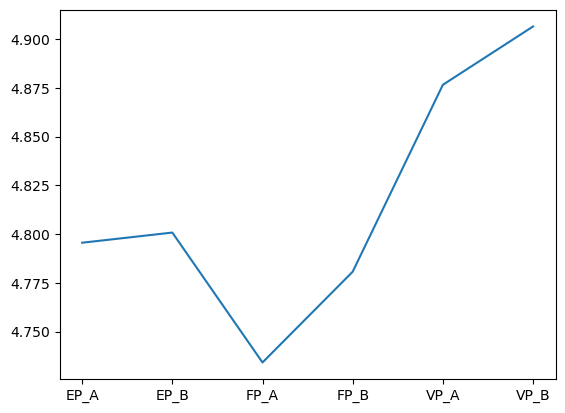

In [32]:
swe_mean_by_praktikum_and_welle.mean(axis=0).plot()

In [33]:
list_praktikums_exclude_MPA[['Praktikum','SWE_norm','geschlecht']].groupby(by=['Praktikum','geschlecht']).agg(['min', 'max', 'mean', 'median', 'std'])

SWE_norm                                        
                              min       max      mean    median       std
Praktikum geschlecht                                                     
EP A      divers/andere  3.599609  3.666016  3.632812  3.632812  0.046956
          männlich            3.0       6.0  5.001243       5.0  0.656062
          weiblich       2.199219       6.0   4.92232       5.0  0.707828
EP B      divers              4.0       4.0       4.0       4.0       NaN
          männlich       3.400391       6.0  4.825857  4.800781  0.636259
          weiblich       2.800781       6.0  4.800105  4.900391  0.683734
FP A      divers         4.398438       5.0  4.699219  4.699219  0.425369
          divers/andere       4.0  5.398438  4.666667  4.601562  0.701488
          männlich       1.599609       6.0   4.85616  4.800781  0.794267
          weiblich       2.800781       6.0  4.815725       5.0  0.733841
FP B      männlich       2.667969       6.0   4.73431  4.800781  0.724754
          weiblich       2.599609       6.0  4.798633       5.0  0.718626
VP A      divers              5.0       5.0       5.0       5.0       NaN
          divers/andere  4.601562  4.601562  4.601562  4.601562       NaN
          männlich       2.599609       6.0  4.791131       5.0  0.649374
          weiblich            3.0       6.0  4.855194       5.0  0.691387
VP B      divers              5.0       5.0       5.0       5.0       NaN
          divers/andere  4.800781  5.667969  5.234375  5.234375  0.613194
          männlich       3.599609       6.0  4.934811       5.0  0.739247
          weiblich       2.333333       6.0  4.853482       5.0  0.751740

In [34]:
list_praktikums_exclude_MPA[['Praktikum','SWE_norm',]].groupby(by=['Praktikum',]).agg(['min', 'max', 'mean', 'median', 'std'])

SWE_norm                                   
                min  max      mean    median       std
Praktikum                                             
EP A       2.199219  6.0  4.928399       5.0  0.703253
EP B       2.800781  6.0  4.800089  4.800781  0.669125
FP A       1.599609  6.0  4.823576       5.0  0.744837
FP B       2.599609  6.0  4.779056       5.0  0.719523
VP A       2.599609  6.0  4.838595       5.0  0.677987
VP B       2.333333  6.0  4.878479       5.0  0.743705

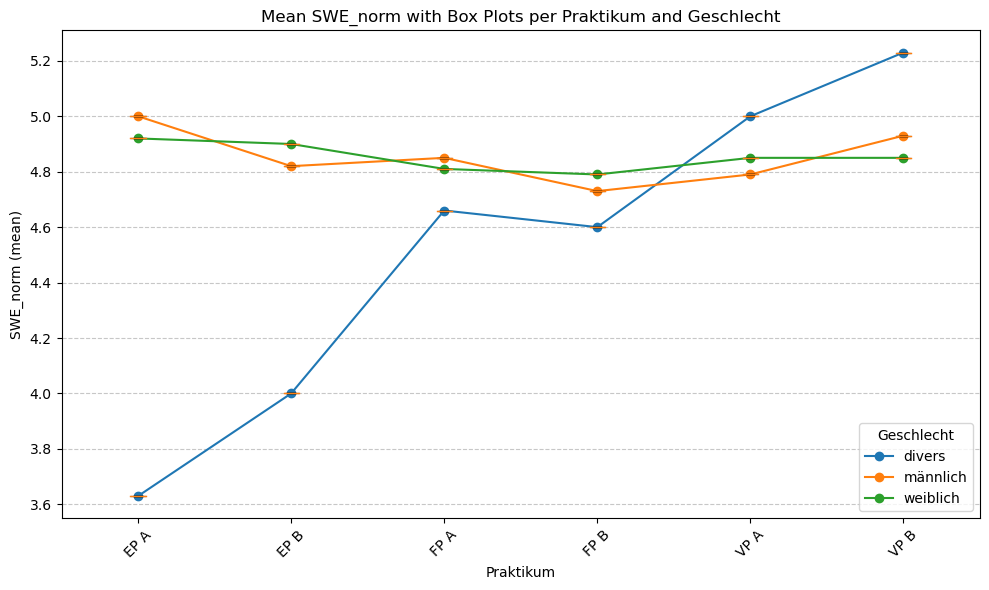

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Replace this with your DataFrame
# Assuming `list_praktikums_exclude_MPAI` contains the data and follows the structure shown in your screenshot
data = {
    'Praktikum': ['EP A', 'EP A', 'EP A', 'EP B', 'EP B', 'EP B', 'FP A', 'FP A', 'FP A', 'FP B', 'FP B', 'FP B', 'VP A', 'VP A', 'VP A', 'VP B', 'VP B', 'VP B'],
    'geschlecht': ['divers', 'männlich', 'weiblich', 'divers', 'männlich', 'weiblich', 'divers', 'männlich', 'weiblich', 'männlich', 'weiblich', 'divers', 'divers', 'männlich', 'weiblich', 'divers', 'männlich', 'weiblich'],
    'mean': [3.63, 5.00, 4.92, 4.00, 4.82, 4.90, 4.66, 4.85, 4.81, 4.73, 4.79, 4.60, 5.00, 4.79, 4.85, 5.23, 4.93, 4.85]
}

df = pd.DataFrame(data)

# Create unique Praktikum order for the x-axis
praktikum_order = df['Praktikum'].unique()

# Separate means by Geschlecht
line_data = df.pivot(index='Praktikum', columns='geschlecht', values='mean')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Line plot for each Geschlecht
for geschlecht in line_data.columns:
    ax.plot(praktikum_order, line_data[geschlecht], marker='o', label=geschlecht)

# Box plot overlay preparation
for idx, praktik in enumerate(praktikum_order):
    subset = df[df['Praktikum'] == praktik]
    box_data = [subset[subset['geschlecht'] == gender]['mean'] for gender in line_data.columns]
    
    # Adding box plots at specific x-positions corresponding to each Praktikum
    ax.boxplot(
        box_data,
        positions=np.full(len(box_data), idx),  # All boxplots for this Praktikum will be centered on its index
        widths=0.1,
        patch_artist=True,
        boxprops=dict(facecolor='lightgray', alpha=0.5)
    )

# Customize plot
ax.set_title('Mean SWE_norm with Box Plots per Praktikum and Geschlecht')
ax.set_xlabel('Praktikum')
ax.set_ylabel('SWE_norm (mean)')
ax.set_xticks(range(len(praktikum_order)))
ax.set_xticklabels(praktikum_order, rotation=45)
ax.legend(title='Geschlecht')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()



In [36]:
# lists_w1_to_w8 = pd.concat([
#     w1_[SELECTED_COLUMNS_ALL],
#     w3_[SELECTED_COLUMNS_ALL],
#     w4_[SELECTED_COLUMNS_ALL],
#     w5_[SELECTED_COLUMNS_ALL],
#     w6_[SELECTED_COLUMNS_ALL],
#     w8_[SELECTED_COLUMNS_ALL],
#     ],axis=0)


date = datetime.now()
op = '%s_%s_%s' % ( date.day, date.month, date.year)

DIR = './NEW_LISTS_DECEMBER/'

list_praktikums_exclude_MPA.reset_index(drop=True).to_csv(f"{DIR}lists_w1_to_w8_COMPLETE{op}.csv")
temp_w1_w6 = pd.read_csv(f"{DIR}lists_w1_to_w8_COMPLETE{op}.csv", index_col=0)
pyreadstat.write_sav(temp_w1_w6, f"{DIR}lists_w1_to_w8_COMPLETE{op}.sav")



In [38]:
list_praktikums_exclude_MPA

,Welle,Praktikum,F_01_norm,F_03_norm,F_09_norm,F_11_norm,F_mean_norm_new,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE_norm,Semester,geschlecht,age
0,w1,FP B,6.0,6.0,4.335938,6.0,5.585938,6.0,6.0,6.0,4.335938,6.0,5.666667,5.0,weiblich,34.0
1,w1,FP A,4.335938,4.335938,2.667969,2.667969,3.503906,6.0,4.335938,4.335938,6.0,6.0,5.333333,5.0,männlich,26.0
2,w1,VP A,4.335938,4.335938,1.0,2.667969,3.085938,2.667969,4.335938,2.667969,4.335938,2.667969,3.333333,7.0,weiblich,23.0
3,w1,VP A,4.335938,6.0,2.667969,2.667969,3.917969,4.335938,4.335938,4.335938,4.335938,6.0,4.666667,7.0,männlich,24.0
4,w1,VP A,2.667969,4.335938,2.667969,2.667969,3.085938,6.0,6.0,6.0,6.0,6.0,6.0,7.0,weiblich,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,w8,VP A,6.0,5.0,6.0,6.0,5.75,6.0,4.0,4.0,6.0,5.0,5.0,10,weiblich,33.0
1182,w8,VP A,4.0,4.0,4.0,3.0,3.75,4.0,5.0,4.0,5.0,6.0,4.800781,8,weiblich,22.0
1183,w8,VP A,3.0,3.0,4.0,5.0,3.75,5.0,5.0,5.0,6.0,6.0,5.398438,8,weiblich,21.0
1184,w8,EP A,5.0,5.0,6.0,5.0,5.25,4.0,5.0,4.0,5.0,5.0,4.601562,2,männlich,20.0


In [37]:
STOP

NameError: name 'STOP' is not defined

In [48]:
SELECTED_COLUMNS_TIMES_W4_W6= [
        'Welle','Praktikum',
        'SWE_01','SWE_02','SWE_03','SWE_04','SWE_05','SWE_norm',
        'F_01_norm', 'F_03_norm', 'F_09_norm', 'F_11_norm', 'F_mean_norm_new',
        'H_PP','H_B', 'H_U',
        'Semester','geschlecht','age']

lists_times_w4_to_w6 = pd.concat([
   
    w4_[SELECTED_COLUMNS_TIMES_W4_W6],
    w5_[SELECTED_COLUMNS_TIMES_W4_W6],
    w6_[SELECTED_COLUMNS_TIMES_W4_W6],
    ],axis=0)

date = datetime.now()
op = '%s_%s_%s' % ( date.day, date.month, date.year)


DIR = './NEW_LISTS_OCTOBER/'

lists_times_w4_to_w6.reset_index(drop=True).to_csv(f"{DIR}lists_w4_to_w6_Times{op}.csv")
temp__ = pd.read_csv(f"{DIR}lists_w4_to_w6_Times{op}.csv", index_col=0)
pyreadstat.write_sav(temp__, f"{DIR}lists_w4_to_w6_Times{op}.sav")

In [47]:
STOP

NameError: name 'STOP' is not defined

In [47]:
## THIS IS TO GENERATE LIST WITH ONLY SWE, AND LGA
SELECTED_COLUMNS_SWE_LGA = [
        'Welle','Praktikum',
        'SWE_01','SWE_02','SWE_03','SWE_04','SWE_05','SWE_norm',
        'LGA_01', 'LGA_02','LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09',
        'Semester','geschlecht','age']

lists_w1_to_w6 = pd.concat([
    w1_[SELECTED_COLUMNS_SWE_LGA],
    w3_[SELECTED_COLUMNS_SWE_LGA],
    w4_[SELECTED_COLUMNS_SWE_LGA],
    w5_[SELECTED_COLUMNS_SWE_LGA],
    w6_[SELECTED_COLUMNS_SWE_LGA],
    ],axis=0)


date = datetime.now()
op = '%s_%s_%s' % ( date.day, date.month, date.year)


DIR = './NEW_LISTS_AUGUST/'


lists_w1_to_w6.reset_index(drop=True).to_csv(f"{DIR}lists_w1_to_w6_{op}.csv")
temp_w1_w6 = pd.read_csv(f"{DIR}lists_w1_to_w6_{op}.csv", index_col=0)
pyreadstat.write_sav(temp_w1_w6, f"{DIR}lists_w1_to_w6_{op}.sav")



In [ ]:
lists_w1_to_w6

,Welle,Praktikum,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE_norm,LGA_01,LGA_02,LGA_03,LGA_04,LGA_05,LGA_06,LGA_07,LGA_08,LGA_09,Semester,geschlecht,age
1,w1,FP B,6.000000,6.000000,6.000000,4.335938,6.000000,5.666667,6.0,5.0,2.0,3.0,4.0,5.0,4.0,6.0,5.0,5.0,weiblich,34
2,w1,FP A,6.000000,4.335938,4.335938,6.000000,6.000000,5.333333,5.0,3.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,5.0,männlich,26
4,w1,VP A,2.667969,4.335938,2.667969,4.335938,2.667969,3.333333,5.0,3.0,3.0,1.0,3.0,2.0,4.0,4.0,1.0,7.0,weiblich,23
5,w1,VP A,4.335938,4.335938,4.335938,4.335938,6.000000,4.666667,5.0,2.0,2.0,1.0,3.0,4.0,2.0,6.0,5.0,7.0,männlich,24
6,w1,VP A,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,4.0,4.0,5.0,2.0,3.0,5.0,3.0,4.0,2.0,7.0,weiblich,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,w6,VP B,6.000000,6.000000,5.000000,6.000000,5.000000,5.601562,6.0,1.0,1.0,1.0,6.0,5.0,5.0,6.0,5.0,8,männlich,25
513,w6,VP B,5.000000,6.000000,5.000000,5.000000,5.000000,5.199219,6.0,5.0,4.0,3.0,6.0,6.0,6.0,5.0,5.0,10,weiblich,27
514,w6,VP B,5.000000,6.000000,5.000000,5.000000,4.000000,5.000000,6.0,4.0,5.0,4.0,6.0,6.0,6.0,5.0,4.0,10,weiblich,27
515,w6,VP B,6.000000,6.000000,5.000000,6.000000,6.000000,5.800781,6.0,6.0,6.0,1.0,6.0,6.0,6.0,4.0,6.0,8,weiblich,22


In [ ]:
stop

In [ ]:

date = datetime.now()
op = '%s_%s_%s' % ( date.day, date.month, date.year)

In [ ]:

W1_NEW_DATA = ['LGA_01', 'LGA_02','LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08','LGA_09']
W1_RA_FP = ['RAFP_01', 'RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07']
W1_RA_VP = ['RAVP_01', 'RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']

W3_NEW_DATA = ['LGA_01', 'LGA_02','LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']
W3_RA_FP = ['RAFP_01', 'RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07']
W3_RA_VP = ['RAVP_01', 'RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']

W4_NEW_DATA = ['LGA_01', 'LGA_02','LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09','nLG_01', 'nLG_02',
       'nLG_03', 'nLG_04', 'nLG_05', 'nLG_06', 'nLG_07', 'nLG_08', 'nLG_09','nLG_10', 'nLG_11', 'nLG_12', 'nLG_13', 
       'nLG_14', 'nLG_15', 'nLG_16','nLG_17', 'nLG_18']

W4_RA_FP = ['RAFP_01', 'RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07']
W4_RA_VP = ['VPLG_00', 'VPLG_01', 'VPLG_02', 'VPLG_03', 'VPLG_04',
       'VPLG_05', 'VPLG_06', 'VPLG_07', 'VPLG_08', 'VPLG_09', 'VPLG_10',
       'VPLG_11', 'VPLG_12', 'VPLG_13', 'VPLG_14', 'VPLG_15', 'VPLG_16',
       'VPLG_17', 'VPLG_18', 'VPLG_19', 'VPLG_20', 'VPLG_21', 'VPLG_22',
       'VPLG_23', 'VPLG_24', 'VPLG_25', 'RAVP_01', 'RAVP_02', 'RAVP_03',
       'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07', 'VPLG_33', 'VPLG_34',
       'VPLG_35', 'VPLG_36', 'VPLG_37', 'VPLG_38', 'VPLG_39', 'VPLG_40',
       'VPLG_41','RAVP_01', 'RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']

W5_NEW_DATA = ['LGA_01','LGA_02', 'LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07',
       'LGA_08', 'LGA_09', 'RA_01', 'RA_02', 'RA_03', 'RA_04', 'RA_05','RA_06', 'RA_07', 'RA_08']

W6_NEW_DATA = ['LGA_01', 'LGA_02','LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08',
       'LGA_09', 'LG_02', 'LG_03', 'LG_04', 'LG_05', 'LG_06', 'LG_07','LG_08', 'LG_09', 'LG_10', 'LG_11', 'LG_12', 'LG_13', 'LG_14',
       'LG_15', 'LG_16', 'LG_17', 'LG_18', 'LG_19', 'LG_20', 'LG_21','LG_22', 'LG_23', 'LG_24', 'LG_25', 'RA_01', 'RA_02', 'RA_03',
       'RA_04', 'RA_05', 'RA_06']

W8_NEW_DATA = ['EBL_01','EBL_02', 'EBL_03', 'EBL_04', 'BNS_01', 'BNS_02', 'BNS_03','BNS_04', 'BNS_05', 'BNS_06', 'BNS_07', 'BNS_08', 'BNS_09']

DIR = './NEW_LISTS_AUGUST/'

w1_[SELECTED_COLUMNS_ALL_2+ W1_NEW_DATA].reset_index(drop=True).to_csv(f"{DIR}list_w1_new_data_{op}.csv")
w1_RA_FP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_FP].reset_index(drop=True).to_csv(f"{DIR}list_w1_new_data_RA_FP_{op}.csv")
w1_RA_VP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_VP].reset_index(drop=True).to_csv(f"{DIR}list_w1_new_data_RA_VP_{op}.csv")

w3_[SELECTED_COLUMNS_ALL_2 + W3_NEW_DATA].reset_index(drop=True).to_csv(f"{DIR}list_w3_new_data_{op}.csv")
w3_RA_FP[SELECTED_COLUMNS_ALL_2 + W3_NEW_DATA+ W3_RA_FP].reset_index(drop=True).to_csv(f"{DIR}list_w3_new_data_RA_FP_{op}.csv")
w3_RA_VP[SELECTED_COLUMNS_ALL_2 + W3_NEW_DATA+ W3_RA_VP].reset_index(drop=True).to_csv(f"{DIR}list_w3_new_data_RA_VP_{op}.csv")

w4_[SELECTED_COLUMNS_ALL_2 + W4_NEW_DATA].reset_index(drop=True).to_csv(f"{DIR}list_w4_new_data_{op}.csv")
w4_RA_FP[SELECTED_COLUMNS_ALL_2 + W4_NEW_DATA+ W4_RA_FP].reset_index(drop=True).to_csv(f"{DIR}list_w4_new_data_RA_FP_{op}.csv")
w4_RA_VP[SELECTED_COLUMNS_ALL_2 + W4_NEW_DATA+ W4_RA_VP].reset_index(drop=True).to_csv(f"{DIR}list_w4_new_data_RA_VP_{op}.csv")

w5_[SELECTED_COLUMNS_ALL_2 + W5_NEW_DATA].reset_index(drop=True).to_csv(f"{DIR}list_w5_new_data_{op}.csv")
w6_[SELECTED_COLUMNS_ALL_2 + W6_NEW_DATA].reset_index(drop=True).to_csv(f"{DIR}list_w6_new_data_{op}.csv")
w8_[SELECTED_COLUMNS_ALL_2 + W8_NEW_DATA].reset_index(drop=True).to_csv(f"{DIR}list_w8_new_data_{op}.csv")

w1_temp_1 = pd.read_csv(f"{DIR}list_w1_new_data_{op}.csv", index_col=0)

w1_temp_2 = pd.read_csv(f"{DIR}list_w1_new_data_RA_FP_{op}.csv", index_col=0)
w1_temp_3 = pd.read_csv(f"{DIR}list_w1_new_data_RA_VP_{op}.csv", index_col=0)

w3_temp_1 = pd.read_csv(f"{DIR}list_w3_new_data_{op}.csv", index_col=0)
w3_temp_2 = pd.read_csv(f"{DIR}list_w3_new_data_RA_FP_{op}.csv", index_col=0)
w3_temp_3 = pd.read_csv(f"{DIR}list_w3_new_data_RA_VP_{op}.csv", index_col=0)

w4_temp_1 = pd.read_csv(f"{DIR}list_w4_new_data_{op}.csv", index_col=0)
w4_temp_2 = pd.read_csv(f"{DIR}list_w4_new_data_RA_FP_{op}.csv", index_col=0)
w4_temp_3 = pd.read_csv(f"{DIR}list_w4_new_data_RA_VP_{op}.csv", index_col=0)

w5_temp = pd.read_csv(f"{DIR}list_w5_new_data_{op}.csv", index_col=0)
w6_temp = pd.read_csv(f"{DIR}list_w6_new_data_{op}.csv", index_col=0)
w8_temp = pd.read_csv(f"{DIR}list_w8_new_data_{op}.csv", index_col=0)

pyreadstat.write_sav(w1_temp_1, f"{DIR}list_w1_new_data_{op}.sav")
pyreadstat.write_sav(w1_temp_2, f"{DIR}list_w1_new_data_RA_FP_{op}.sav")
pyreadstat.write_sav(w1_temp_3, f"{DIR}list_w1_new_data_RA_VP_{op}.sav")

pyreadstat.write_sav(w3_temp_1,f"{DIR}list_w3_new_data_{op}.sav")
pyreadstat.write_sav(w3_temp_2,f"{DIR}list_w3_new_data_RA_FP_{op}.sav")
pyreadstat.write_sav(w3_temp_3,f"{DIR}list_w3_new_data_RA_VP_{op}.sav")

pyreadstat.write_sav(w4_temp_1,f"{DIR}list_w4_new_data_{op}.sav")
pyreadstat.write_sav(w4_temp_2,f"{DIR}list_w4_new_data_RA_FP_{op}.sav")
pyreadstat.write_sav(w4_temp_3,f"{DIR}list_w4_new_data_RA_VP_{op}.sav")

pyreadstat.write_sav(w5_temp,f"{DIR}list_w5_new_data_{op}.sav")
pyreadstat.write_sav(w6_temp,f"{DIR}list_w6_new_data_{op}.sav")
pyreadstat.write_sav(w8_temp,f"{DIR}list_w8_new_data_{op}.sav")




# pyreadstat.write_sav(w3_[SELECTED_COLUMNS_ALL_2 + W3_NEW_DATA].reset_index(), f"{DIR}list_w3_new_data_{op}.sav")
# pyreadstat.write_sav(w3_RA_FP[SELECTED_COLUMNS_ALL_2 + W3_NEW_DATA+ W3_RA_FP].reset_index(), f"{DIR}list_w3_RA_FP_new_data_{op}.sav")
# pyreadstat.write_sav(w3_RA_VP[SELECTED_COLUMNS_ALL_2 + W3_NEW_DATA+ W3_RA_VP].reset_index(), f"{DIR}list_w3_RA_VP_new_data_{op}.sav")


# pyreadstat.write_sav(w4_[SELECTED_COLUMNS_ALL_2 + W4_NEW_DATA].reset_index(), f"{DIR}list_w4_new_data_{op}.sav")
# pyreadstat.write_sav(w4_RA_FP[SELECTED_COLUMNS_ALL_2 + W4_NEW_DATA+ W4_RA_FP].reset_index(), f"{DIR}list_w4_RA_FP_new_data_{op}.sav")
# pyreadstat.write_sav(w4_RA_VP[SELECTED_COLUMNS_ALL_2 + W4_NEW_DATA+ W4_RA_VP].reset_index(), f"{DIR}list_w4_RA_VP_new_data_{op}.sav")

# pyreadstat.write_sav(w5_[SELECTED_COLUMNS_ALL_2 + W5_NEW_DATA].reset_index(), f"{DIR}list_w5_new_data_{op}.sav")

# pyreadstat.write_sav(w6_[SELECTED_COLUMNS_ALL_2 + W6_NEW_DATA].reset_index(), f"{DIR}list_w6_new_data_{op}.sav")

# pyreadstat.write_sav(w8_[SELECTED_COLUMNS_ALL_2 + W8_NEW_DATA].reset_index(), f"{DIR}list_w8_new_data_{op}.sav")



In [ ]:


pyreadstat.write_sav(list_praktikums_2.reset_index(), f"list_praktikums_{op}.sav")

# for n,w in zip(wellen_names,wellen):
#     file = f"./lists_{op}/{n}_list.sav"
#     print(file)
#     pyreadstat.write_sav(pd.DataFrame(w.values, columns=selected_columns), file)

In [ ]:
list_praktikums_2.reset_index()

,index,Welle,Praktikum,F_01,F_03,F_09,F_11,F_norm,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE_norm,Semester,geschlecht,age
0,0,w1,FP B,4.0,4.0,3.0,4.0,5.667969,6.0,6.0,6.0,4.335938,6.0,5.666667,5.0,weiblich,34
1,1,w1,FP A,3.0,3.0,2.0,2.0,3.666016,6.0,4.335938,4.335938,6.0,6.0,5.333333,5.0,männlich,26
2,2,w1,VP A,3.0,3.0,1.0,2.0,3.0,2.667969,4.335938,2.667969,4.335938,2.667969,3.333333,7.0,weiblich,23
3,3,w1,VP A,3.0,4.0,2.0,2.0,3.666016,4.335938,4.335938,4.335938,4.335938,6.0,4.666667,7.0,männlich,24
4,4,w1,VP A,2.0,3.0,2.0,2.0,3.333984,6.0,6.0,6.0,6.0,6.0,6.0,7.0,weiblich,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,1188,w8,VP A,6.0,5.0,6.0,6.0,5.398438,6.0,4.0,4.0,6.0,5.0,5.0,10,weiblich,33
1189,1189,w8,VP A,4.0,4.0,4.0,3.0,3.599609,4.0,5.0,4.0,5.0,6.0,4.800781,8,weiblich,22
1190,1190,w8,VP A,3.0,3.0,4.0,5.0,3.199219,5.0,5.0,5.0,6.0,6.0,5.398438,8,weiblich,21
1191,1191,w8,EP A,5.0,5.0,6.0,5.0,5.199219,4.0,5.0,4.0,5.0,5.0,4.601562,2,männlich,20


In [ ]:
list_praktikums_2_boxcox = list_praktikums_2.reset_index().drop([6, 190, 358, 421]).copy()

In [ ]:

boxcox, maxlog = stats.boxcox(list_praktikums_2_boxcox['F_norm'].values.astype(float))

In [ ]:
boxcox2, maxlog2 = stats.boxcox(list_praktikums_2_boxcox['SWE_norm'].values.astype(float))

In [ ]:
maxlog2

2.27741053851742

In [ ]:
list_praktikums_2_boxcox['BoxCox_F_norm'] = boxcox
list_praktikums_2_boxcox['maxlog'] = maxlog

In [ ]:
pyreadstat.write_sav(list_praktikums_2_boxcox, f"list_praktikums_{op}_updated.sav")

In [ ]:
list_praktikums_2_boxcox

,index,Welle,Praktikum,F_01,F_03,F_09,F_11,F_norm,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE_norm,Semester,geschlecht,age,BoxCox_F_norm,maxlog
0,0,w1,FP B,4.0,4.0,3.0,4.0,5.667969,6.0,6.0,6.0,4.335938,6.0,5.666667,5.0,weiblich,34,31.805010,2.538232
1,1,w1,FP A,3.0,3.0,2.0,2.0,3.666016,6.0,4.335938,4.335938,6.0,6.0,5.333333,5.0,männlich,26,10.260318,2.538232
2,2,w1,VP A,3.0,3.0,1.0,2.0,3.0,2.667969,4.335938,2.667969,4.335938,2.667969,3.333333,7.0,weiblich,23,6.010935,2.538232
3,3,w1,VP A,3.0,4.0,2.0,2.0,3.666016,4.335938,4.335938,4.335938,4.335938,6.0,4.666667,7.0,männlich,24,10.260318,2.538232
4,4,w1,VP A,2.0,3.0,2.0,2.0,3.333984,6.0,6.0,6.0,6.0,6.0,6.0,7.0,weiblich,24,7.978839,2.538232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,1188,w8,VP A,6.0,5.0,6.0,6.0,5.398438,6.0,4.0,4.0,6.0,5.0,5.0,10,weiblich,33,28.059466,2.538232
1189,1189,w8,VP A,4.0,4.0,4.0,3.0,3.599609,4.0,5.0,4.0,5.0,6.0,4.800781,8,weiblich,22,9.777262,2.538232
1190,1190,w8,VP A,3.0,3.0,4.0,5.0,3.199219,5.0,5.0,5.0,6.0,6.0,5.398438,8,weiblich,21,7.146301,2.538232
1191,1191,w8,EP A,5.0,5.0,6.0,5.0,5.199219,4.0,5.0,4.0,5.0,5.0,4.601562,2,männlich,20,25.469418,2.538232


In [ ]:
list_praktikums_2_boxcox['Praktikum'].value_counts()

Praktikum
VP A    269
FP A    244
FP B    231
VP B    187
EP A    147
EP B    110
MP A      1
Name: count, dtype: int64

In [ ]:
_, maxlog = stats.boxcox(list_praktikums[list_praktikums['Praktikum']=='VP A']['SWE_norm'].values.astype(float))
print("VP A",maxlog)

_, maxlog = stats.boxcox(list_praktikums[list_praktikums['Praktikum']=='FP A']['SWE_norm'].values.astype(float))
print("FP A",maxlog)

_, maxlog = stats.boxcox(list_praktikums[list_praktikums['Praktikum']=='FP B']['SWE_norm'].values.astype(float))
print("FP B",maxlog)

_, maxlog = stats.boxcox(list_praktikums[list_praktikums['Praktikum']=='VP B']['SWE_norm'].values.astype(float))
print("VP B",maxlog)

_, maxlog = stats.boxcox(list_praktikums[list_praktikums['Praktikum']=='EP A']['SWE_norm'].values.astype(float))
print("EP A",maxlog)

_, maxlog = stats.boxcox(list_praktikums[list_praktikums['Praktikum']=='EP B']['SWE_norm'].values.astype(float))
print("EP B",maxlog)

# _, maxlog = stats.boxcox(list_praktikums[list_praktikums['Praktikum']=='MP A']['SWE_norm'].values.astype(float))
# print("MP A",maxlog)

VP A 2.2600118327031273
FP A 2.6035093167471
FP B 2.332355666795009
VP B 1.9398641724536212
EP A 2.3284187030688543
EP B 1.8864088841043058


In [ ]:
def someFunction(group):
    _, maxlog = stats.boxcox(group['F_norm'].values.astype(float))
    _, maxlog2 = stats.boxcox(group['SWE_norm'].values.astype(float))
    group['boxcox_F' ] = maxlog
    group['boxcox_SWE' ] = maxlog2
    return maxlog, maxlog2


In [ ]:

print("F_boxcox, SWE_boxcox")
list_praktikums[list_praktikums['Praktikum']!='MP A'].groupby(by=['Praktikum']).apply(someFunction)

F_boxcox, SWE_boxcox


Praktikum
EP A    (2.9846354357169247, 2.3284187030688543)
EP B    (2.5443950894379324, 1.8864088841043058)
FP A       (2.5227445721532127, 2.6035093167471)
FP B      (2.350342173413367, 2.332355666795009)
VP A    (2.3165617511440257, 2.2600118327031273)
VP B    (2.7767504208046065, 1.9398641724536212)
dtype: object

In [ ]:
SELECTED_COLUMNS_ALL_2

['Welle',
 'Praktikum',
 'F_01',
 'F_03',
 'F_09',
 'F_11',
 'F_norm',
 'SWE_01',
 'SWE_02',
 'SWE_03',
 'SWE_04',
 'SWE_05',
 'SWE_norm',
 'Semester',
 'geschlecht',
 'age']

## EXTRA NEW LISTS NEW DATA

In [ ]:



# w1_[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA]
# w1_RA_FP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_FP]
# w1_RA_VP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_VP]

In [ ]:
w8_.columns.values

array(['Praktikum', 'P_absolviert', 'SW01_01', 'SW01_02', 'SW01_03',
       'SW01_04', 'SW01_05', 'FINISHED', 'TIME_SUM', 'SD05', 'geschlecht',
       'age', 'F_01', 'F_03', 'F_04', 'F_09', 'F_11', 'SD04', 'EBL_01',
       'EBL_02', 'EBL_03', 'EBL_04', 'BNS_01', 'BNS_02', 'BNS_03',
       'BNS_04', 'BNS_05', 'BNS_06', 'BNS_07', 'BNS_08', 'BNS_09',
       'Welle', 'SWE', 'SWE_01', 'SWE_02', 'SWE_03', 'SWE_04', 'SWE_05',
       'SWE_norm', 'SWE_norm_new', 'F_mean', 'F_01_norm', 'F_03_norm',
       'F_04_norm', 'F_09_norm', 'F_11_norm', 'F_mean_norm_new',
       'F_3mean', 'F_norm', 'F_3norm', 'Semester'], dtype=object)

In [ ]:



# w3_[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA]
# w3_RA_FP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_FP]
# w3_RA_VP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_VP]

In [ ]:



# w4_[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA]
# w4_RA_FP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_FP]
# w4_RA_VP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_VP]


In [ ]:

W1_NEW_DATA = ['LGA_01', 'LGA_02','LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08','LGA_09']
W1_RA_FP = ['RAFP_01', 'RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07']
W1_RA_VP = ['RAVP_01', 'RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']

W3_NEW_DATA = ['LGA_01', 'LGA_02','LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09']
W3_RA_FP = ['RAFP_01', 'RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07']
W3_RA_VP = ['RAVP_01', 'RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']

W4_NEW_DATA = ['LGA_01', 'LGA_02','LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08', 'LGA_09','nLG_01', 'nLG_02',
       'nLG_03', 'nLG_04', 'nLG_05', 'nLG_06', 'nLG_07', 'nLG_08', 'nLG_09','nLG_10', 'nLG_11', 'nLG_12', 'nLG_13', 
       'nLG_14', 'nLG_15', 'nLG_16','nLG_17', 'nLG_18']

W4_RA_FP = ['RAFP_01', 'RAFP_02', 'RAFP_03', 'RAFP_04', 'RAFP_05', 'RAFP_06', 'RAFP_07']
W4_RA_VP = ['VPLG_00', 'VPLG_01', 'VPLG_02', 'VPLG_03', 'VPLG_04',
       'VPLG_05', 'VPLG_06', 'VPLG_07', 'VPLG_08', 'VPLG_09', 'VPLG_10',
       'VPLG_11', 'VPLG_12', 'VPLG_13', 'VPLG_14', 'VPLG_15', 'VPLG_16',
       'VPLG_17', 'VPLG_18', 'VPLG_19', 'VPLG_20', 'VPLG_21', 'VPLG_22',
       'VPLG_23', 'VPLG_24', 'VPLG_25', 'RAVP_01', 'RAVP_02', 'RAVP_03',
       'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07', 'VPLG_33', 'VPLG_34',
       'VPLG_35', 'VPLG_36', 'VPLG_37', 'VPLG_38', 'VPLG_39', 'VPLG_40',
       'VPLG_41','RAVP_01', 'RAVP_02', 'RAVP_03', 'RAVP_04', 'RAVP_05', 'RAVP_06', 'RAVP_07']

W5_NEW_DATA = ['LGA_01','LGA_02', 'LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07',
       'LGA_08', 'LGA_09', 'RA_01', 'RA_02', 'RA_03', 'RA_04', 'RA_05','RA_06', 'RA_07', 'RA_08']

W6_NEW_DATA = ['LGA_01', 'LGA_02','LGA_03', 'LGA_04', 'LGA_05', 'LGA_06', 'LGA_07', 'LGA_08',
       'LGA_09', 'LG_02', 'LG_03', 'LG_04', 'LG_05', 'LG_06', 'LG_07','LG_08', 'LG_09', 'LG_10', 'LG_11', 'LG_12', 'LG_13', 'LG_14',
       'LG_15', 'LG_16', 'LG_17', 'LG_18', 'LG_19', 'LG_20', 'LG_21','LG_22', 'LG_23', 'LG_24', 'LG_25', 'RA_01', 'RA_02', 'RA_03',
       'RA_04', 'RA_05', 'RA_06']

W8_NEW_DATA = ['EBL_01','EBL_02', 'EBL_03', 'EBL_04', 'BNS_01', 'BNS_02', 'BNS_03','BNS_04', 'BNS_05', 'BNS_06', 'BNS_07', 'BNS_08', 'BNS_09']

DIR = './NEW_LISTS_AUGUST/'
pyreadstat.write_sav(w1_[SELECTED_COLUMNS_ALL_2+ W1_NEW_DATA].reset_index(), f"{DIR}w1_{op}.sav")
pyreadstat.write_sav(w1_RA_FP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_FP].reset_index(), f"{DIR}list_w1_RA_PF_new_data_{op}.sav")
pyreadstat.write_sav(w1_RA_VP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_VP].reset_index(), f"{DIR}list_w1_RA_VP_new_data_{op}.sav")

pyreadstat.write_sav(w3_[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA].reset_index(), f"{DIR}list_w3_new_data_{op}.sav")
pyreadstat.write_sav(w3_RA_FP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_FP].reset_index(), f"{DIR}list_w3_RA_FP_new_data_{op}.sav")
pyreadstat.write_sav(w3_RA_VP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_VP].reset_index(), f"{DIR}list_w3_RA_VP_new_data_{op}.sav")


pyreadstat.write_sav(w4_[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA].reset_index(), f"{DIR}list_w4_new_data_{op}.sav")
pyreadstat.write_sav(w4_RA_FP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_FP].reset_index(), f"{DIR}list_w4_RA_FP_new_data_{op}.sav")
pyreadstat.write_sav(w4_RA_VP[SELECTED_COLUMNS_ALL_2 + W1_NEW_DATA+ W1_RA_VP].reset_index(), f"{DIR}list_w4_RA_VP_new_data_{op}.sav")

pyreadstat.write_sav(w5_[SELECTED_COLUMNS_ALL_2 + W5_NEW_DATA].reset_index(), f"{DIR}list_w5_new_data_{op}.sav")

pyreadstat.write_sav(w6_[SELECTED_COLUMNS_ALL_2 + W6_NEW_DATA].reset_index(), f"{DIR}list_w6_new_data_{op}.sav")

pyreadstat.write_sav(w8_[SELECTED_COLUMNS_ALL_2 + W8_NEW_DATA].reset_index(), f"{DIR}list_w8_new_data_{op}.sav")



ReadstatError: A provided string value was longer than the available storage size of the specified column

In [ ]:
print(pyreadstat.__version__)

1.2.2


## Age

In [ ]:
all_wellen = pd.concat(wellen)

In [ ]:
all_wellen

,Welle,Praktikum,SWE,SWE_norm,Semester,geschlecht,age
1,w1,FP B,3.800000,5.700000,5.0,weiblich,34
2,w1,FP A,3.600000,5.400000,5.0,männlich,26
4,w1,VP A,2.400000,3.600000,7.0,weiblich,23
5,w1,VP A,3.200000,4.800000,7.0,männlich,24
13,w1,FP B,3.800000,5.700000,5.0,weiblich,34
...,...,...,...,...,...,...,...
575,w8,FP B,5.398438,5.398438,6,weiblich,24
576,w8,VP A,4.800781,4.800781,8,weiblich,22
577,w8,VP A,5.398438,5.398438,8,weiblich,21
578,w8,EP A,4.601562,4.601562,2,männlich,20


In [ ]:
all_wellen[['Welle','geschlecht','age']].groupby(by=["Welle","geschlecht"]).agg(['count','min', 'max','median','mean','std'])

age                                    
                    count min max median       mean       std
Welle geschlecht                                             
w1    männlich         69  20  36   24.0  25.086957  3.604487
      weiblich        150  20  44   22.0  23.773333  4.375261
w3    männlich         24  19  35   24.0  25.000000  4.854402
      weiblich         99  18  46   22.0  23.262626  5.583478
w4    divers/andere     2  19  22   20.5  20.500000  2.121320
      männlich         66  19  48   22.0  24.424242  6.256223
      weiblich        149  18  43   21.0  22.389262  4.432240
w5    divers/andere     2  21  24   22.5  22.500000  2.121320
      männlich         33  18  35   23.0  24.000000  4.235269
      weiblich         78  18  47   22.0  23.794872  5.865060
w6    divers/andere     4  21  24   22.0  22.250000  1.500000
      männlich        141  18  48   22.0  23.354610  4.294739
      weiblich        328  18  47   21.0  22.344512  3.779904
w8    divers            5  20  25   22.0  22.400000  2.073644
      männlich        137  19  50   24.0  24.956204  5.346616
      weiblich        375  18  50   22.0  23.536000  4.970841

In [ ]:
all_wellen[['Welle','age']].groupby(by=["Welle"]).agg(['min', 'max','median','mean','std'])

age                                
      min max median       mean       std
Welle                                    
w1     20  44   23.0  24.187215  4.184574
w3     18  46   22.0  23.601626  5.473842
w4     18  48   21.0  22.990783  5.118043
w5     18  47   22.0  23.831858  5.371723
w6     18  48   22.0  22.644820  3.949450
w8     18  50   23.0  23.901354  5.088361

In [ ]:
all_wellen[(all_wellen["Welle"] == "w3") & (all_wellen["geschlecht"] == "weiblich")]['age'].mean()

23.262626262626263

In [ ]:
w1_stats = w1_[['SWE']].describe().T.reset_index()
w3_stats = w3_[['KO01_01','KO01_02','KO01_03','KO01_04','KO01_05']].describe().T.reset_index()
w4_stats = w4_[['KO01_01','KO01_02','KO01_03','KO01_04','KO01_05']].describe().T.reset_index()
w5_stats = w5_[['KO01_01','KO01_02','KO01_03','KO01_04','KO01_05']].describe().T.reset_index()
w6_stats = w6_[['KO01_01','KO01_02','KO01_03','KO01_04','KO01_05']].describe().T.reset_index()
w8_stats = w8_[['SW01_01','SW01_02','SW01_03','SW01_04','SW01_05']].describe().T.reset_index()
w1_stats['Welle'] = "W1"
w3_stats['Welle'] = "W3"
w4_stats['Welle'] = "W4"
w5_stats['Welle'] = "W5"
w6_stats['Welle'] = "W6"
w8_stats['Welle'] = "W8"
stats = pd.concat([w1_stats, w3_stats, w4_stats, w5_stats, w6_stats, w8_stats])

stats.set_index(['Welle',"index"], inplace=True)
stats.rename(index={"index": "Frage"}, inplace=True)

In [ ]:
stats


count      mean       std  min  25%  50%  75%  max
Welle index                                                      
W1    SWE      219.0  3.284018  0.414275  1.8  3.0  3.4  3.6  4.0
W3    KO01_01  123.0  3.138672  0.761230  1.0  3.0  3.0  4.0  4.0
      KO01_02  123.0  3.179688  0.747070  1.0  3.0  3.0  4.0  4.0
      KO01_03  123.0  2.894531  0.776855  1.0  2.0  3.0  3.0  4.0
      KO01_04  123.0  3.308594  0.714355  1.0  3.0  3.0  4.0  4.0
      KO01_05  123.0  3.251953  0.719727  1.0  3.0  3.0  4.0  4.0
W4    KO01_01  217.0  3.419922  0.655273  1.0  3.0  4.0  4.0  4.0
      KO01_02  217.0  3.501953  0.609375  1.0  3.0  4.0  4.0  4.0
      KO01_03  217.0  3.027344  0.706543  1.0  3.0  3.0  3.0  4.0
      KO01_04  217.0  3.521484  0.562012  2.0  3.0  4.0  4.0  4.0
      KO01_05  217.0  3.437500  0.606445  2.0  3.0  3.0  4.0  4.0
W5    KO01_01  113.0  4.921875  0.825195  3.0  4.0  5.0  5.0  6.0
      KO01_02  113.0  5.019531  0.755859  3.0  5.0  5.0  6.0  6.0
      KO01_03  113.0  4.292969  1.107422  1.0  4.0  4.0  5.0  6.0
      KO01_04  113.0  4.859375  0.885254  2.0  4.0  5.0  5.0  6.0
      KO01_05  113.0  4.839844  1.013672  2.0  4.0  5.0  6.0  6.0
W6    KO01_01  473.0  5.007812  0.890137  1.0  5.0  5.0  6.0  6.0
      KO01_02  473.0  5.023438  0.984863  1.0  5.0  5.0  6.0  6.0
      KO01_03  473.0  4.402344  1.044922  1.0  4.0  4.0  5.0  6.0
      KO01_04  473.0  5.031250  0.893066  2.0  5.0  5.0  6.0  6.0
      KO01_05  473.0  5.085938  0.884766  1.0  5.0  5.0  6.0  6.0
W8    SW01_01  517.0  4.855469  1.038086  1.0  4.0  5.0  6.0  6.0
      SW01_02  517.0  4.867188  1.057617  1.0  4.0  5.0  6.0  6.0
      SW01_03  517.0  4.148438  1.187500  1.0  3.0  4.0  5.0  6.0
      SW01_04  517.0  4.890625  1.019531  1.0  4.0  5.0  6.0  6.0
      SW01_05  517.0  4.882812  1.017578  1.0  4.0  5.0  6.0  6.0